# How Zipfian Was My Baby?

In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

## Read data and group by year and gender

In [2]:
df = pd.read_csv("data/NationalNames.csv")
gb = df.groupby(['Year','Gender'], sort=False)

In [3]:
df.loc[:,'Freq_yearly'] = gb['Count'].transform(lambda x: 100. * x / x.sum())
df.loc[:,'Cum_freq_yearly'] = gb['Freq_yearly'].cumsum()

df.loc[:,'Rank_yearly'] = gb['Count'].rank(ascending=False)

df.loc[:,"Pct_yearly"] = gb['Id'].transform(lambda x: 100.0 / x.count())
df.loc[:,"Cum_pct_yearly"] = gb['Pct_yearly'].cumsum()

## Compute the approximate Zipfian distribution

In [ ]:
df.loc[:,'Zipf'] = gb['Rank_yearly'].transform(lambda x: 100. / (x * np.log(1.78 * x.count())))

In [ ]:
ax = zipf_plotter(1984,y='Zipf')
zipf_plotter(1984,y='Freq_yearly', ax=ax)

In [ ]:
def zipf_plotter(from_year, until_year=None, step=1, 
                 x='Rank_yearly', logx=True, 
                 y='Freq_yearly', logy=True,
                 gender="F",
                 ax=None):
  if ax is None:
    _, ax = plt.subplots(1, 1)
    
  if until_year is None:
    until_year = from_year + 1
    title = str(from_year)
  else:
    title = "%d - %d" % (from_year, until_year-1)
      
  years = range(from_year, until_year, step)
  for year in years:
    idx = np.logical_and(df.Year == year, df.Gender == gender)
    df.loc[idx, :].plot(kind="line", x=x, y=y, logx=logx, logy=logy, ax=ax)

  ax.set_title(title)
  
  for t, s in zip(ax.legend().get_texts(), years):
    t.set_text(s)
    
  return ax

In [ ]:
zipf_plotter(1884, 1915, 6)
zipf_plotter(1984, 2015, 6)

In [ ]:
ax = zipf_plotter(1884, 1985, 100, x="Cum_pct_yearly", logx=False, gender="M")
ax.set_xlabel("Percent of total names")
ax.set_ylabel("Name frequency")

In [ ]:
zipf_plotter(1884, 1915, 6, x="Cum_pct_yearly", logx=False)
zipf_plotter(1984, 2015, 6, x="Cum_pct_yearly", logx=False)

## Look at the frequency of most popular names by year

The plot below shows the frequency of the most popular name by year. Based on this plot, one might conclude that American names are becoming less Zipfian. 

In [ ]:
_, ax = plt.subplots(1, 1)
s = gb['Freq_yearly'].max().reset_index()
genders = ['F','M']
for gender in genders:
  s.loc[s.Gender == gender,:].plot.line('Year','Freq_yearly', ax=ax)
  
for t, g in zip(ax.legend().get_texts(), genders):
  t.set_text(g)
  
ax.set_ylabel("% people having most popular name")

## The 80-20 rule

How many people share the top 20% of all names?

In [ ]:
df_top20 = df.loc[df.Cum_pct_yearly <= 20.0, :].groupby(['Year','Gender'], sort=False)['Freq_yearly'].sum().reset_index()
df_top20 = df_top20.rename(columns={'Freq_yearly':'Freq_yearly_top20'})

fig, ax = plt.subplots(1, 1)
for gender in ['F','M']:
  df_top20.loc[df_top20.Gender == gender,:].plot.line('Year','Freq_yearly_top20', ax=ax)
  
for x, s in zip(ax.legend().get_texts(), ['F', 'M']):
  x.set_text(s)
  
_ = ax.set_ylabel("% people having 20th percentile name ")

## What is going on?


In [ ]:
zipf_plotter(1884, 2015, 65, x="Cum_pct_yearly")

## Interesting evolutions of names

In [ ]:
def comp_maker(name, gender, name_fun=(lambda x, g: x)):
  return (df.loc[(df.Name == name) & (df.Gender == gender), ["Year", "Freq_yearly"]]
                             .set_index("Year").T.rename(index={"Freq_yearly":name_fun(name, gender)}).copy())


def compare_names(names_genders, name_fun=(lambda x, g: x), logy=False):
  df_cand = pd.DataFrame()
  for name, gender in names_genders:
    df_cand = df_cand.append(comp_maker(name, gender, name_fun))

  ax = df_cand.T.plot.line(logy=logy)
  ax.set_ylabel("Yearly Frequency")
  return ax

In [ ]:
compare_names([("Donald","M"), ("Gary", "M"), ("Hillary", "F"), ("Jill", "F")])

In [ ]:
compare_names([("Hillary", "F"),("Hillary","M")], lambda n,g: "%s: %s" % (n,g), logy=True)

In [ ]:
compare_names([("Donald", "F"),("Donald","M")], lambda n,g: "%s: %s" % (n,g), logy=True)

In [ ]:
names = ["Hillary", "Lindsey", "Leslie", "Stephanie"]
for name in names:
  compare_names([(name, "F"),(name,"M")], lambda n,g: "%s: %s" % (n,g), logy=True)

## Gender-shifting names

In [4]:
df_mf = df.set_index(["Year","Name"])
df_ratio = df_mf.loc[df_mf.Gender == "F",["Freq_yearly"]].join(df_mf.loc[df_mf.Gender == "M","Freq_yearly"], 
                                                 rsuffix="_M", how="inner")
df_ratio["Ratio"] = df_ratio.Freq_yearly_M / df_ratio.Freq_yearly

df_ratio = df_ratio.reset_index().groupby('Name').filter(lambda x: len(x) > 90)

alpha = 5.0 # how much more prevalent was one name than the other, in terms of frequency
df_ratio = df_ratio.groupby("Name").filter(lambda x: x.Ratio.max() > alpha and x.Ratio.min() < (1/alpha))

df_ratio.groupby("Name").count().count()

Year             28
Freq_yearly      28
Freq_yearly_M    28
Ratio            28
dtype: int64

In [6]:
df.plot?

/Users/joshuaarnold/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


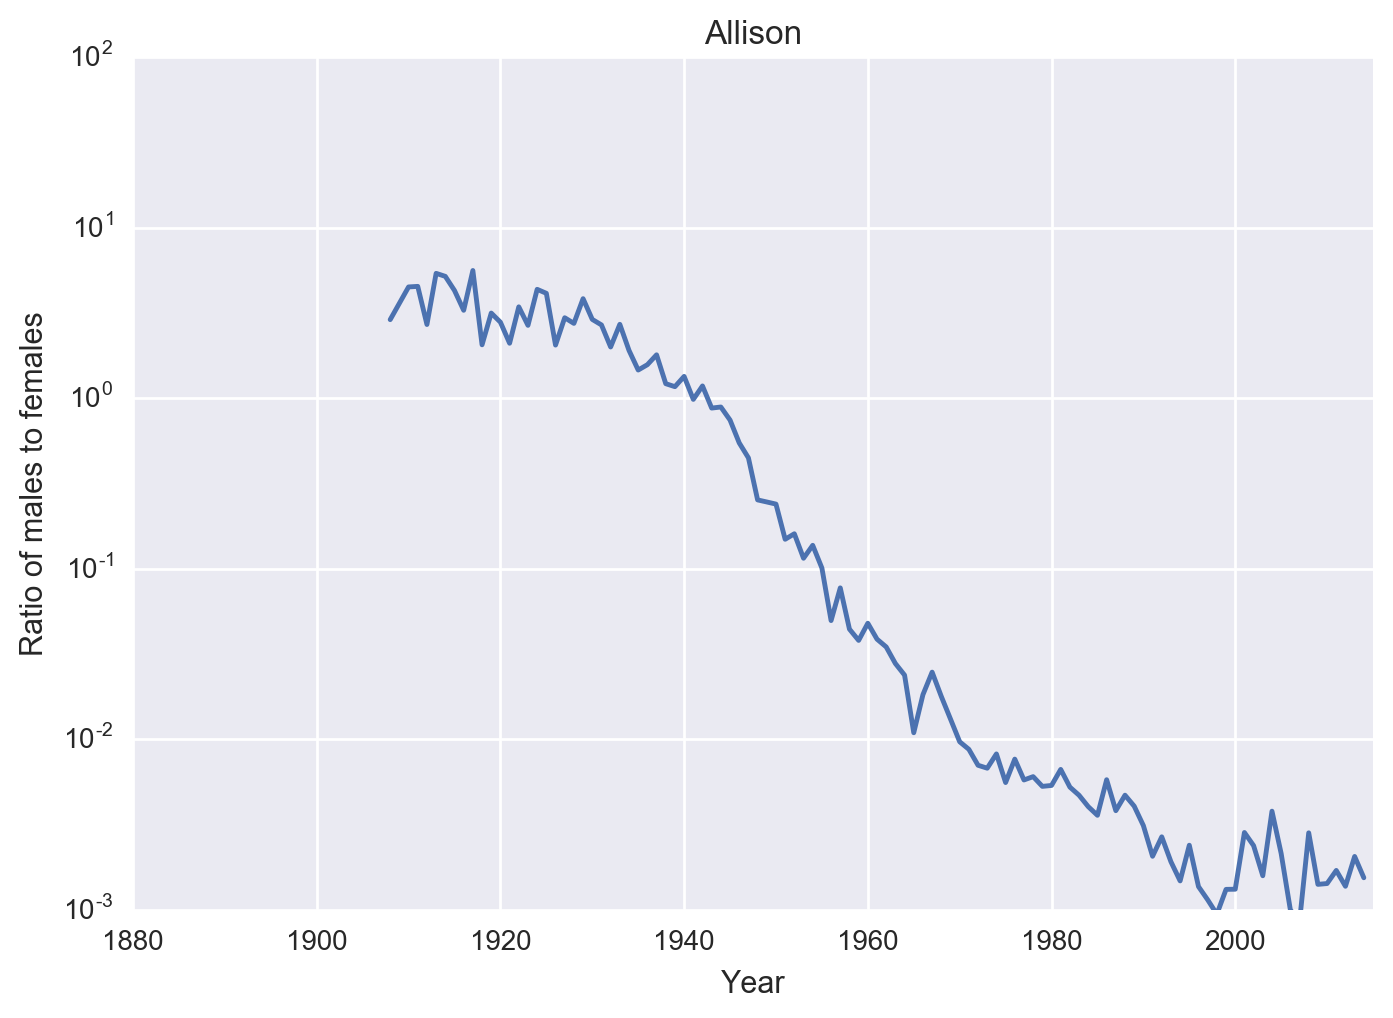

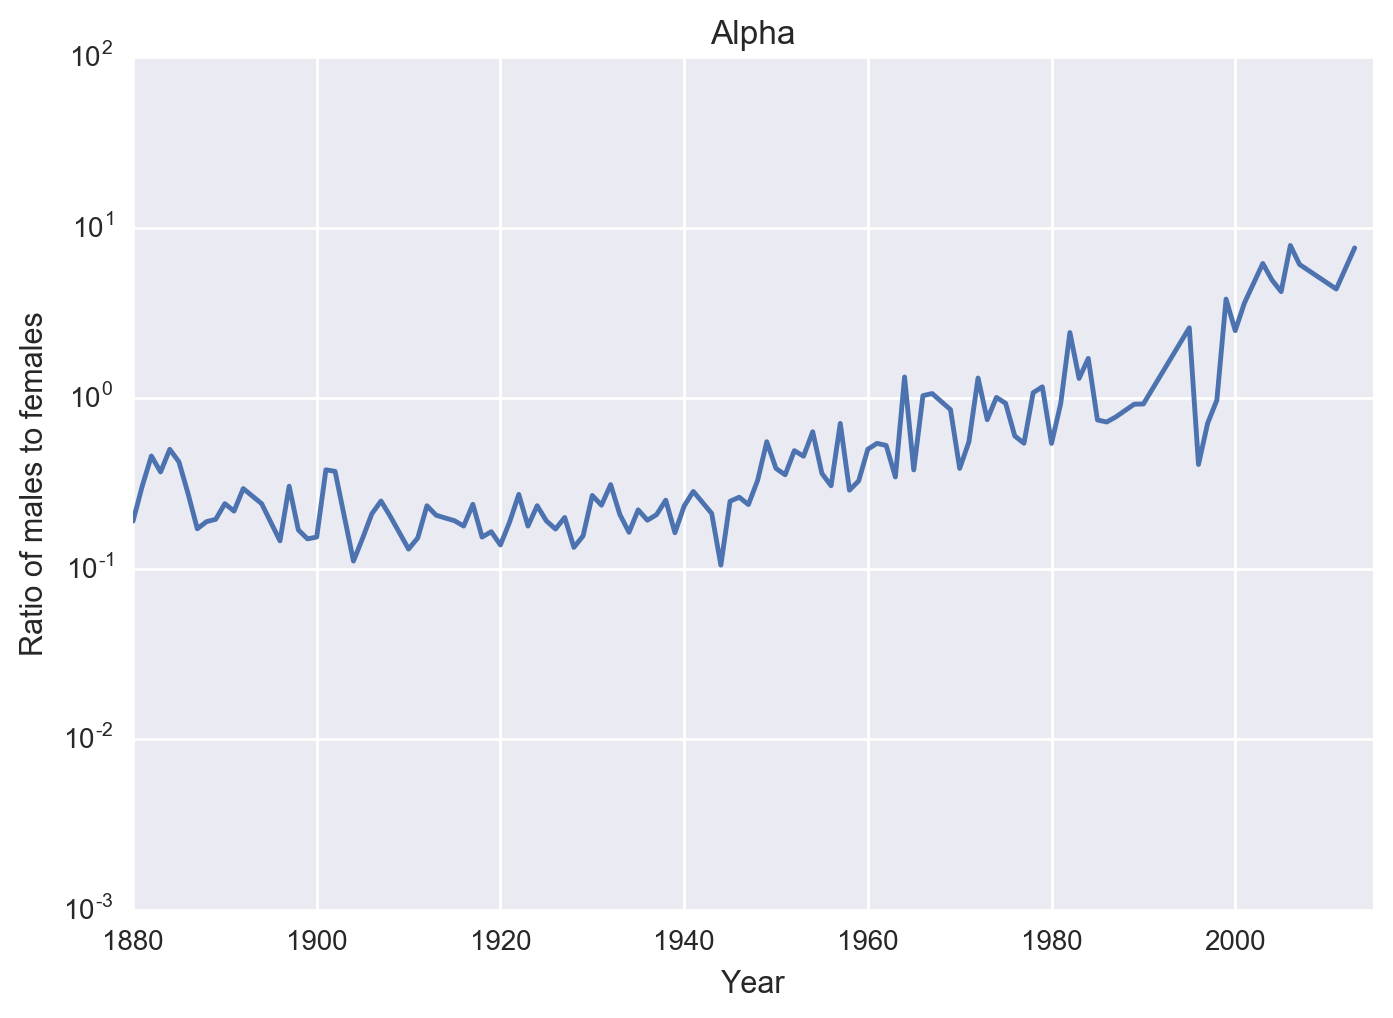

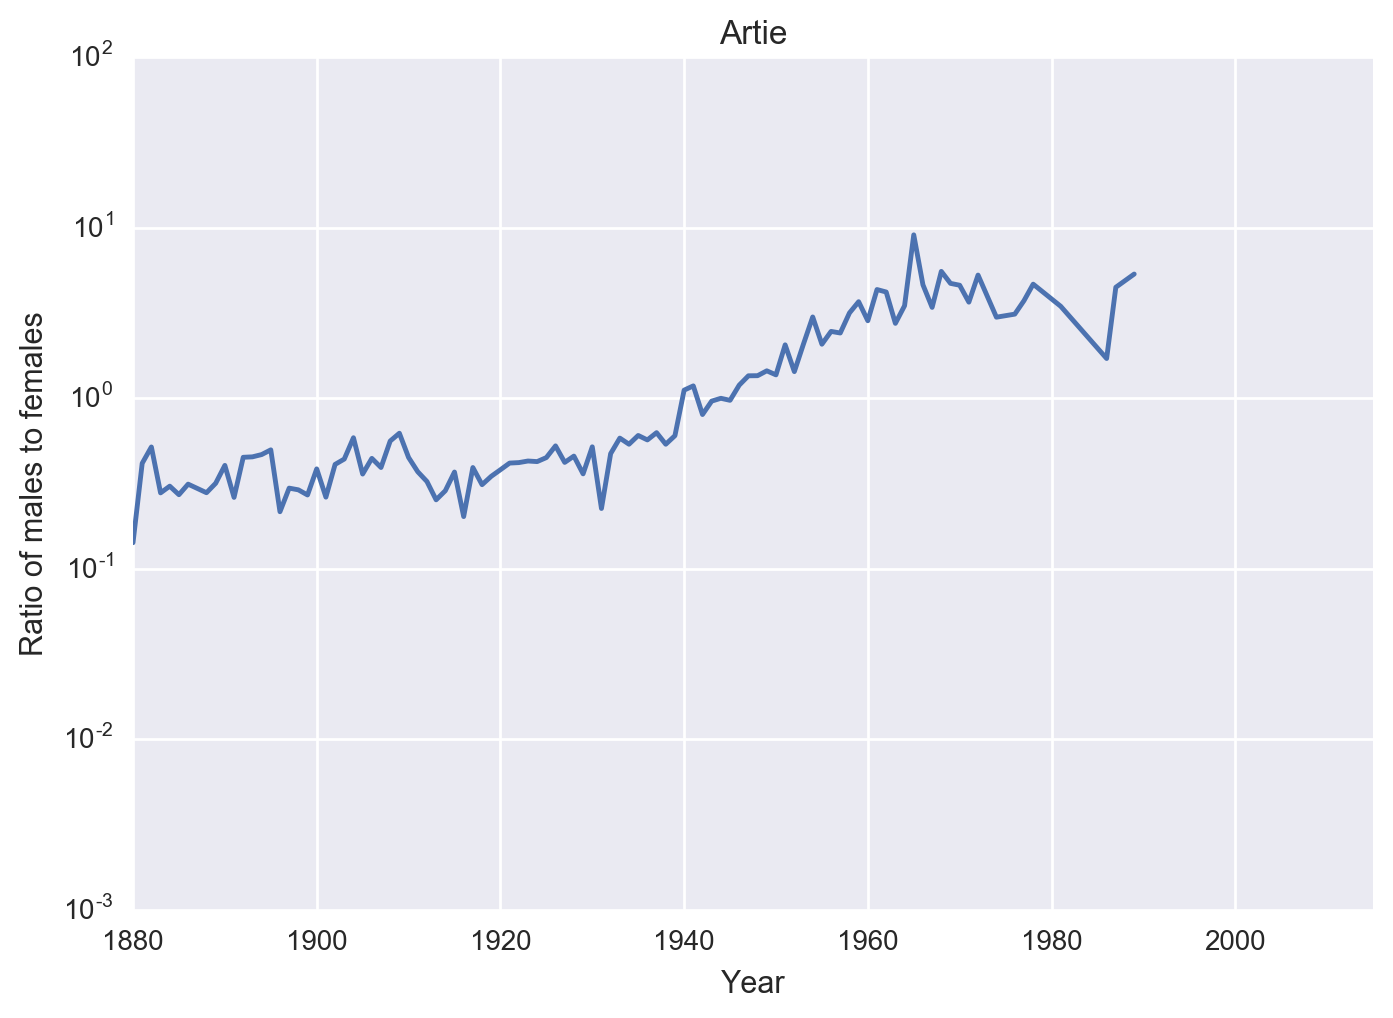

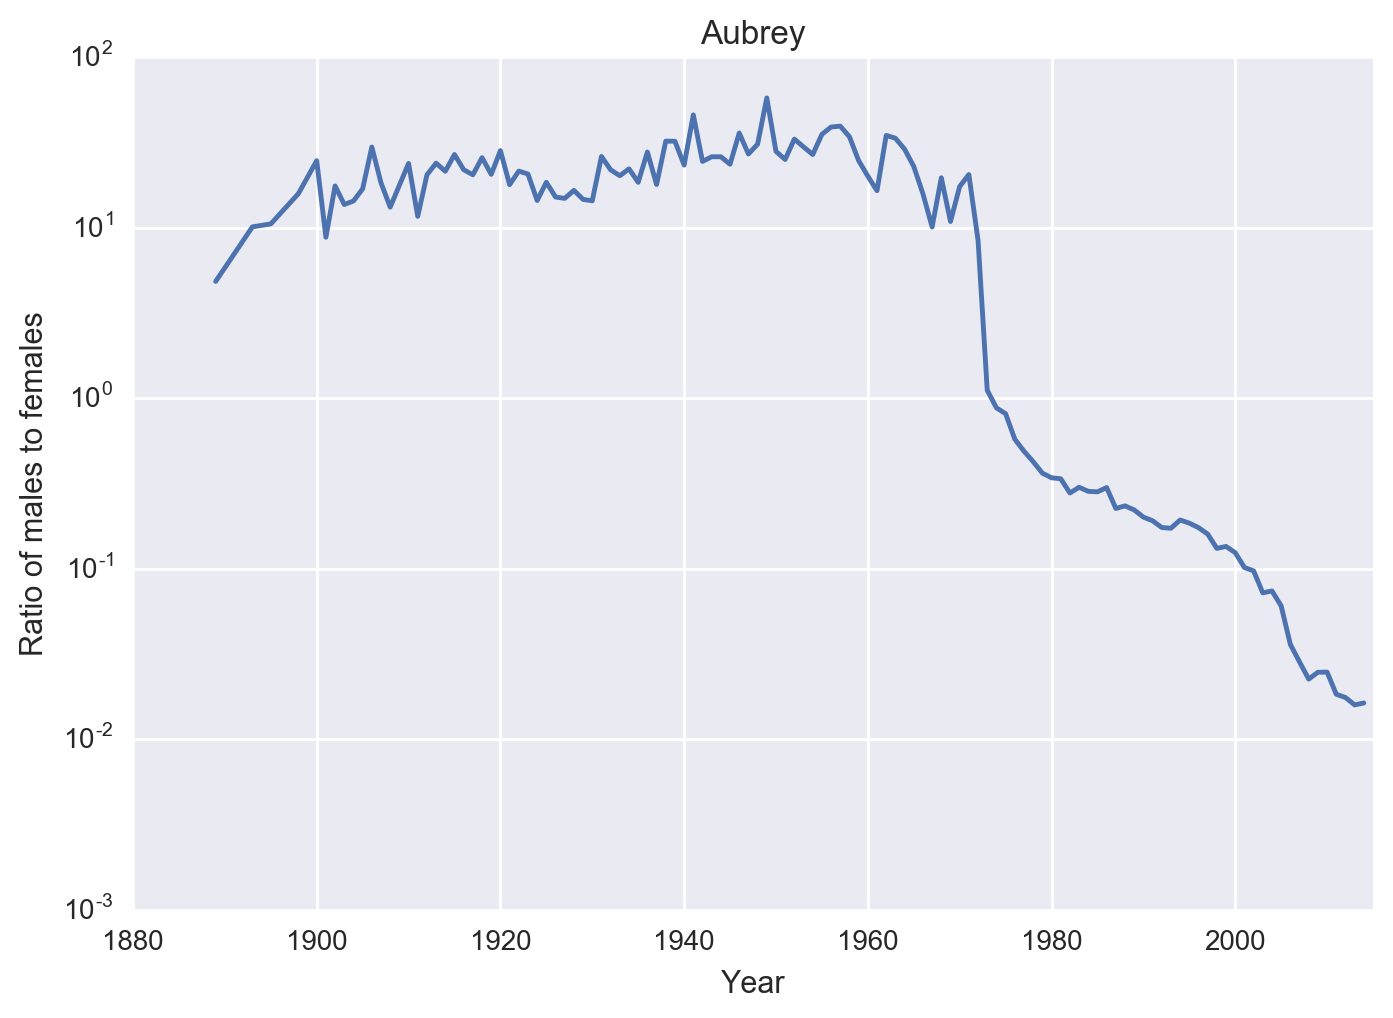

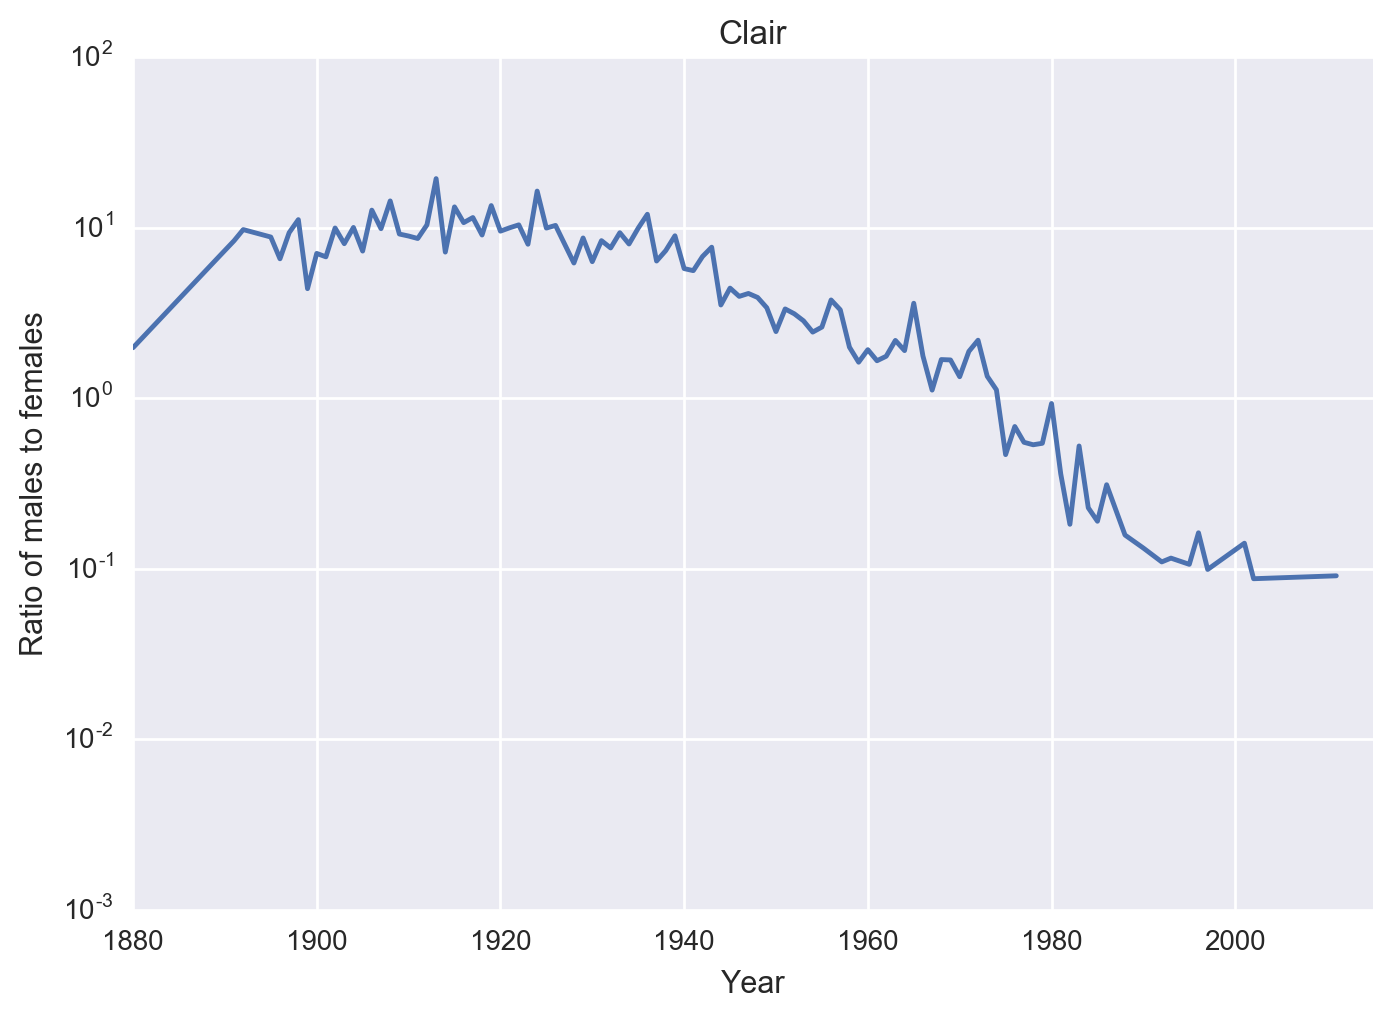

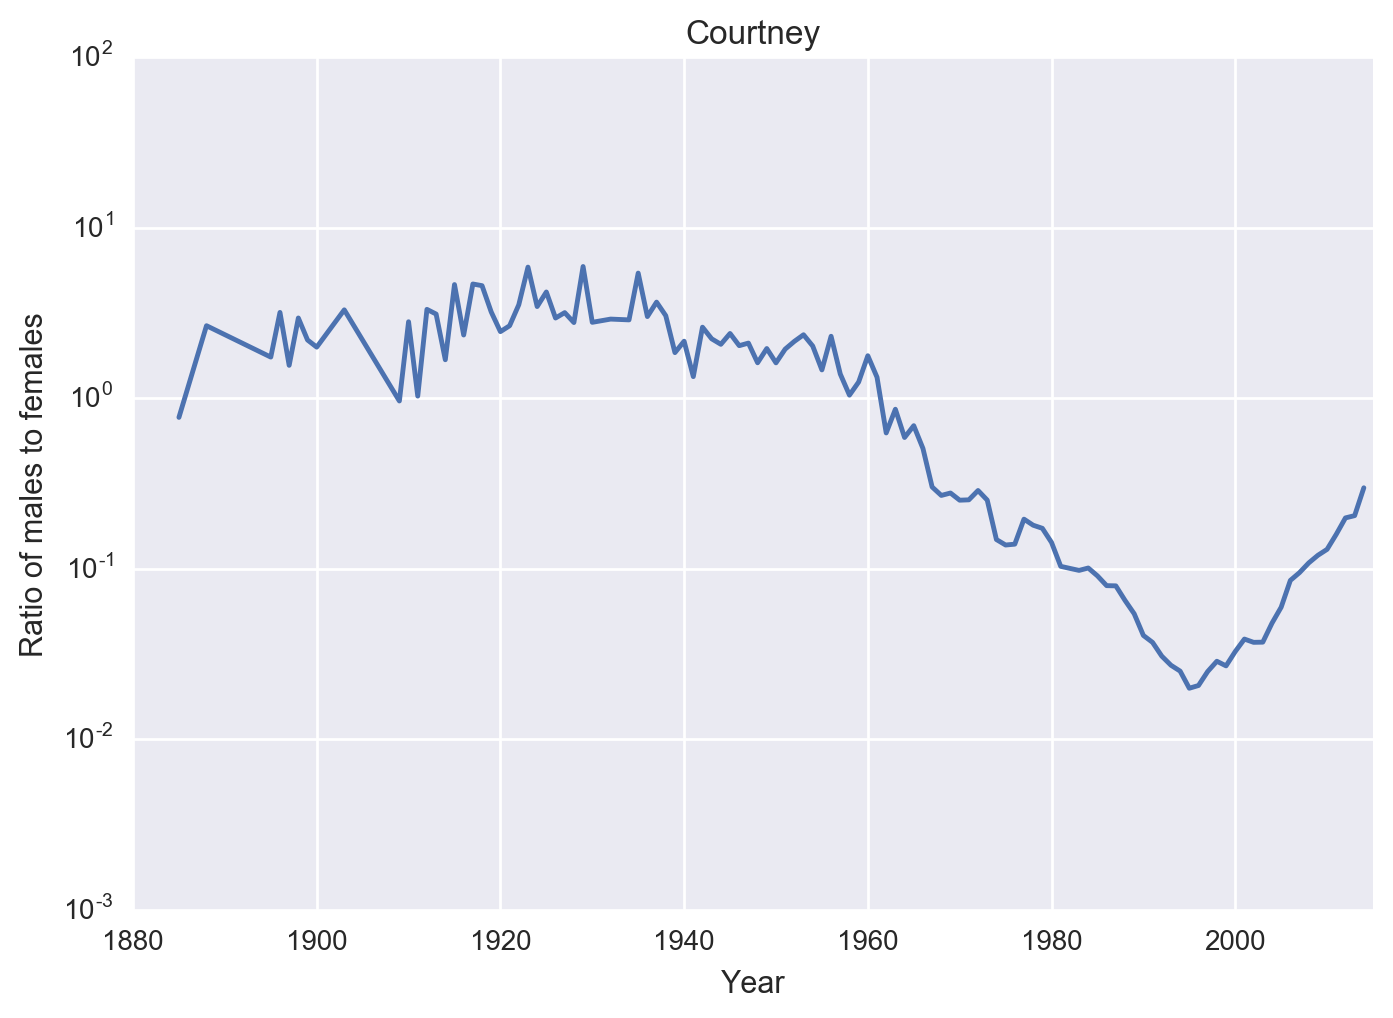

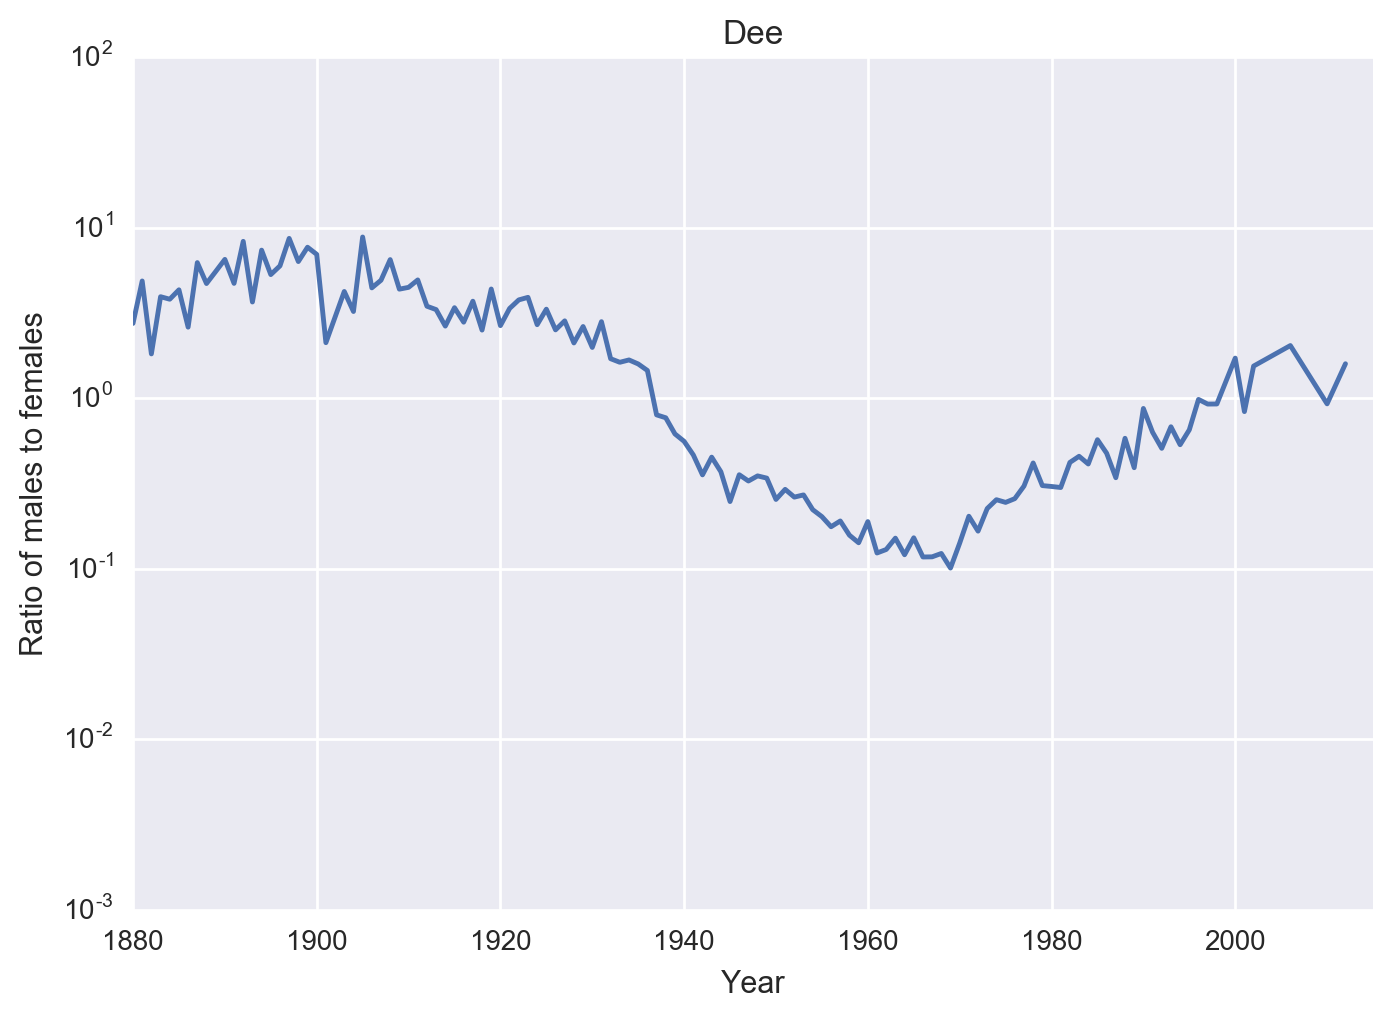

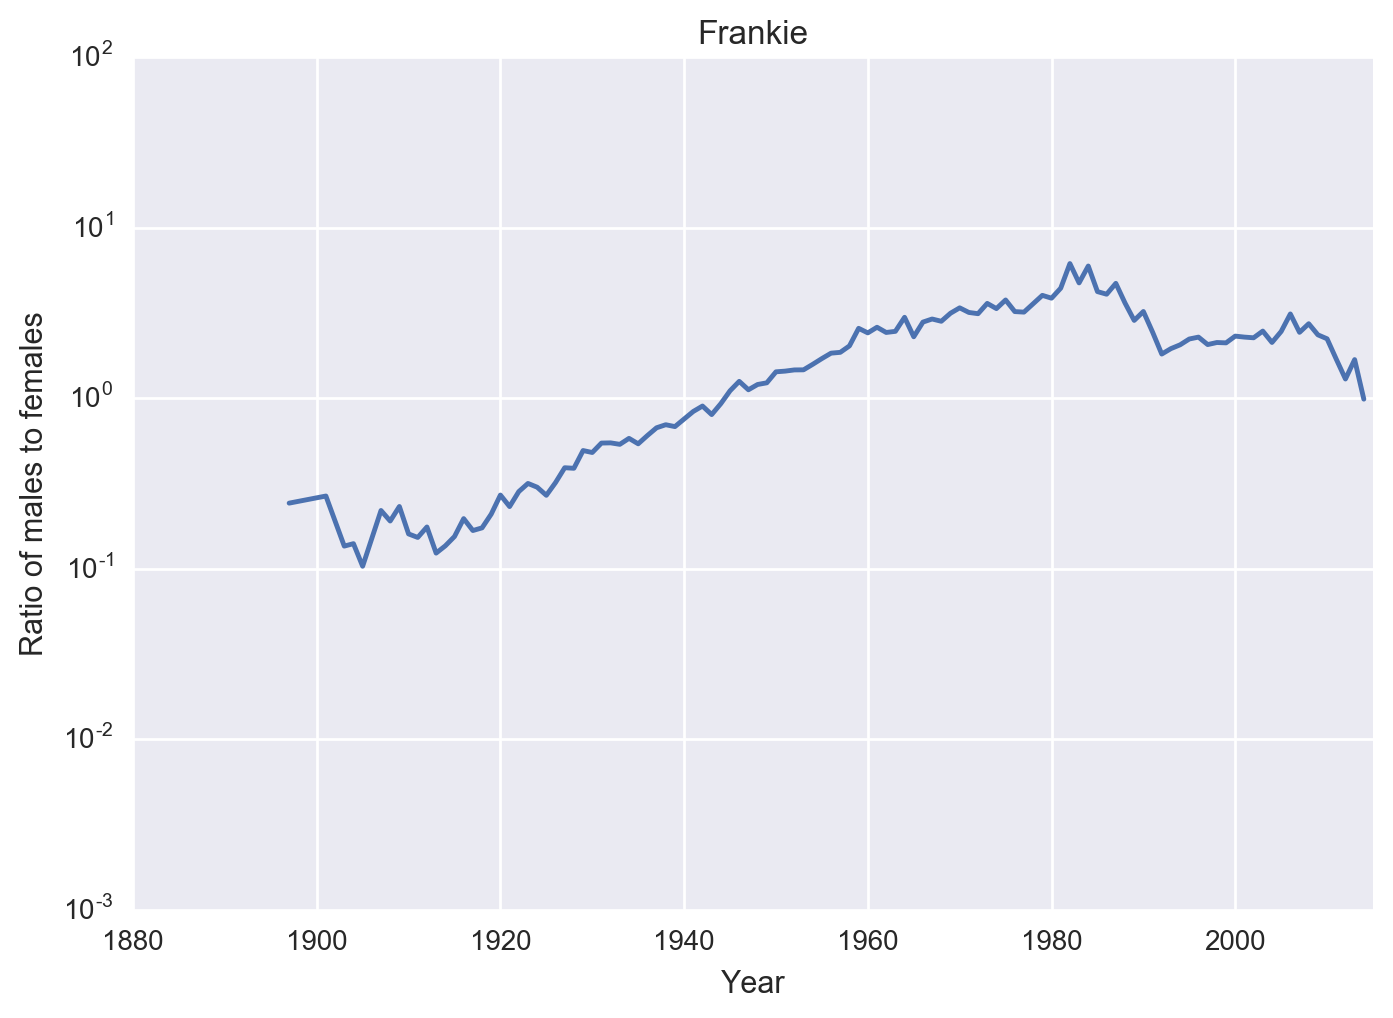

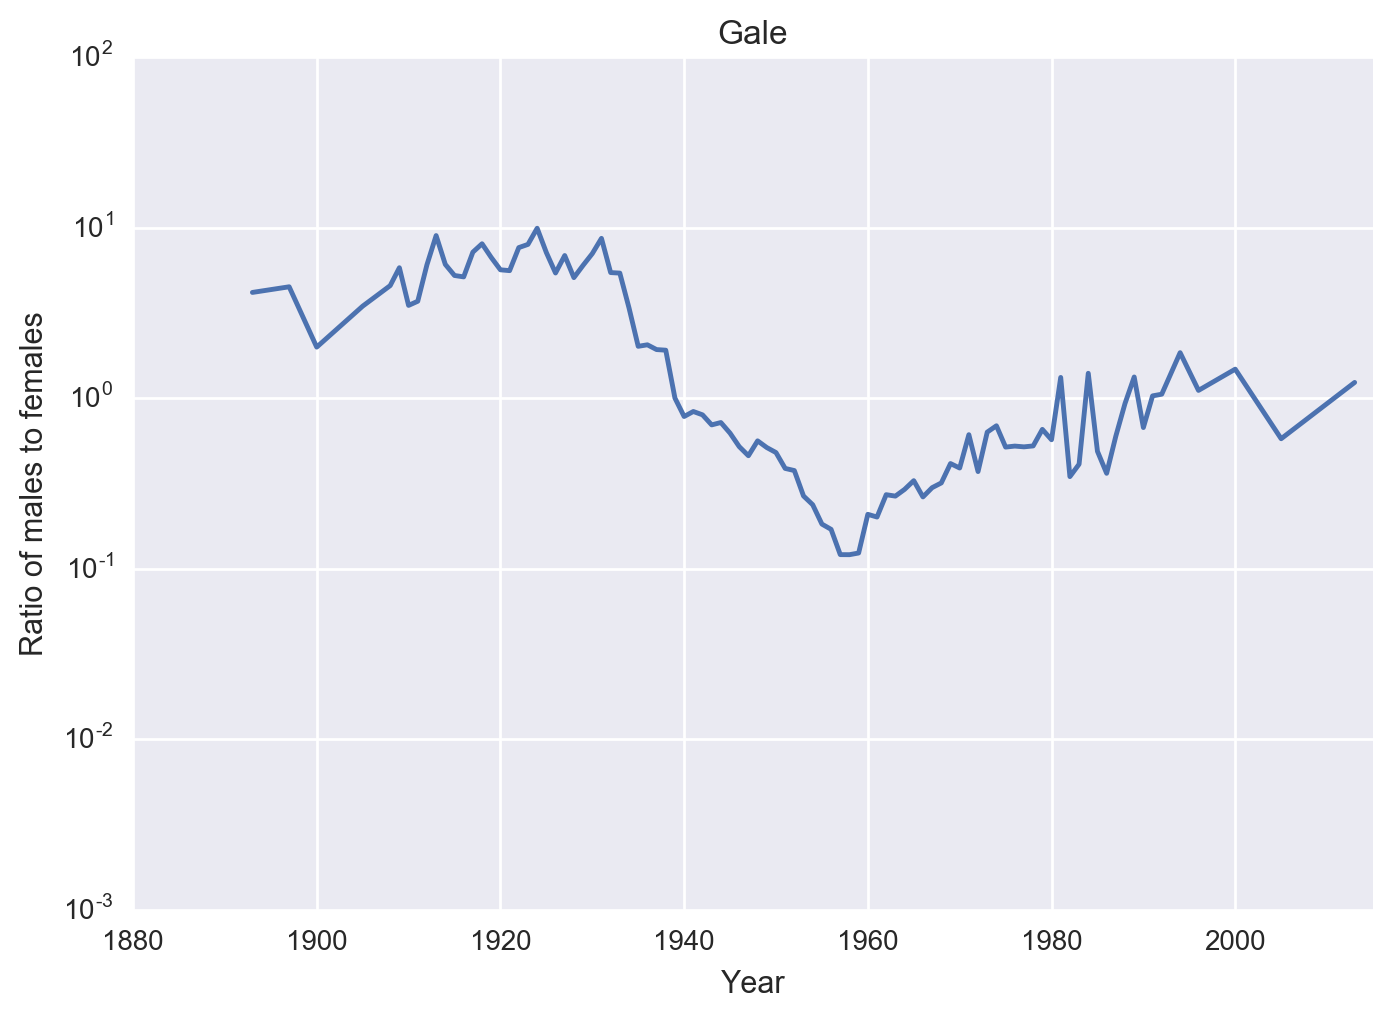

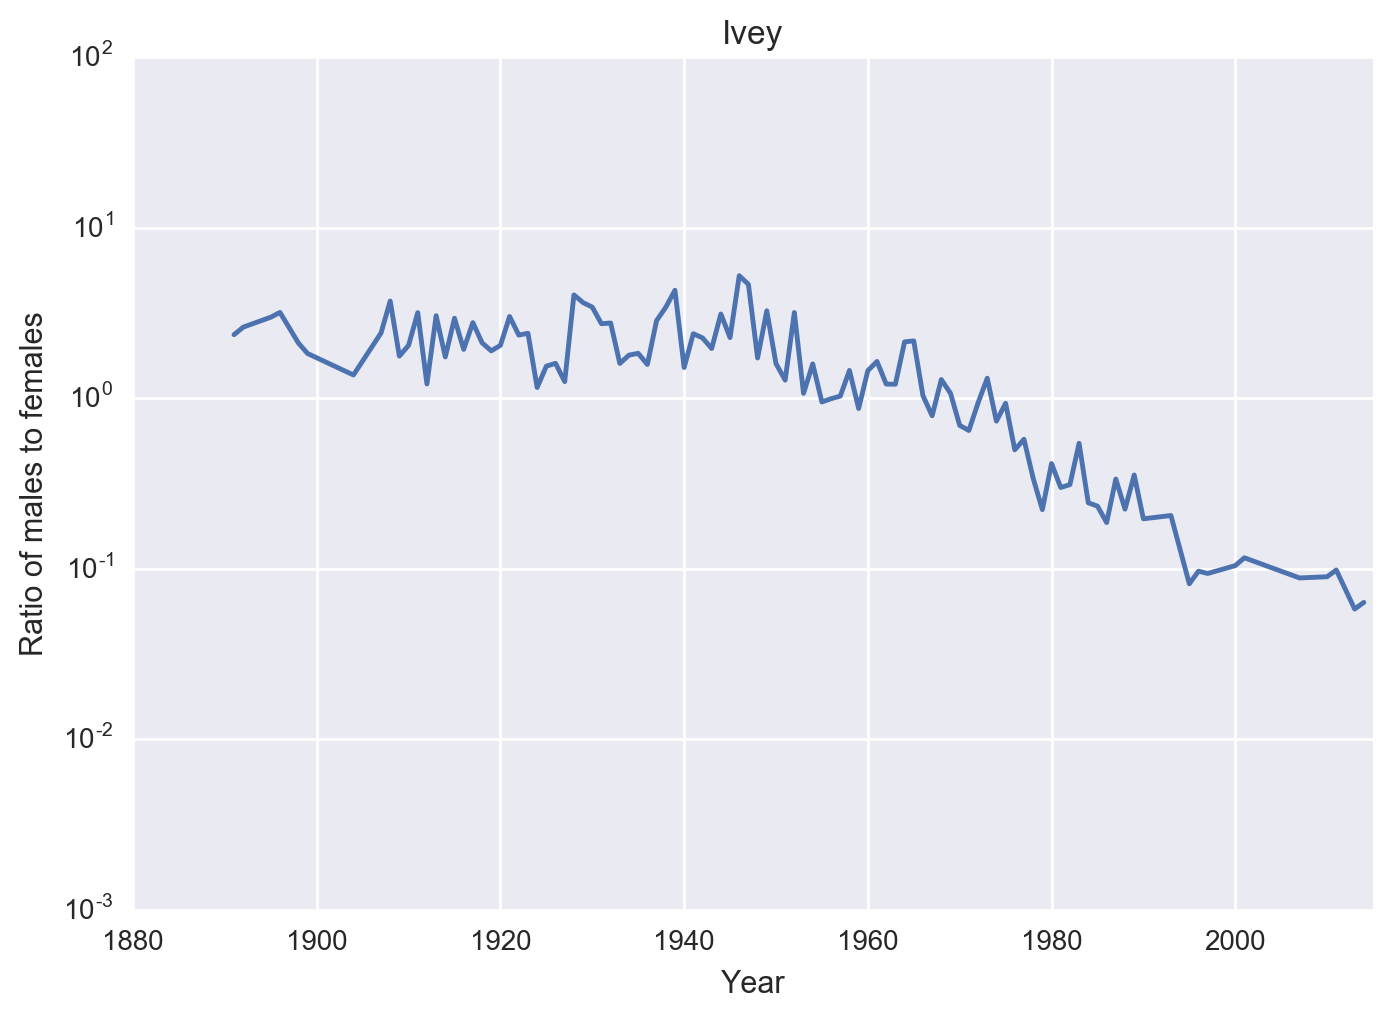

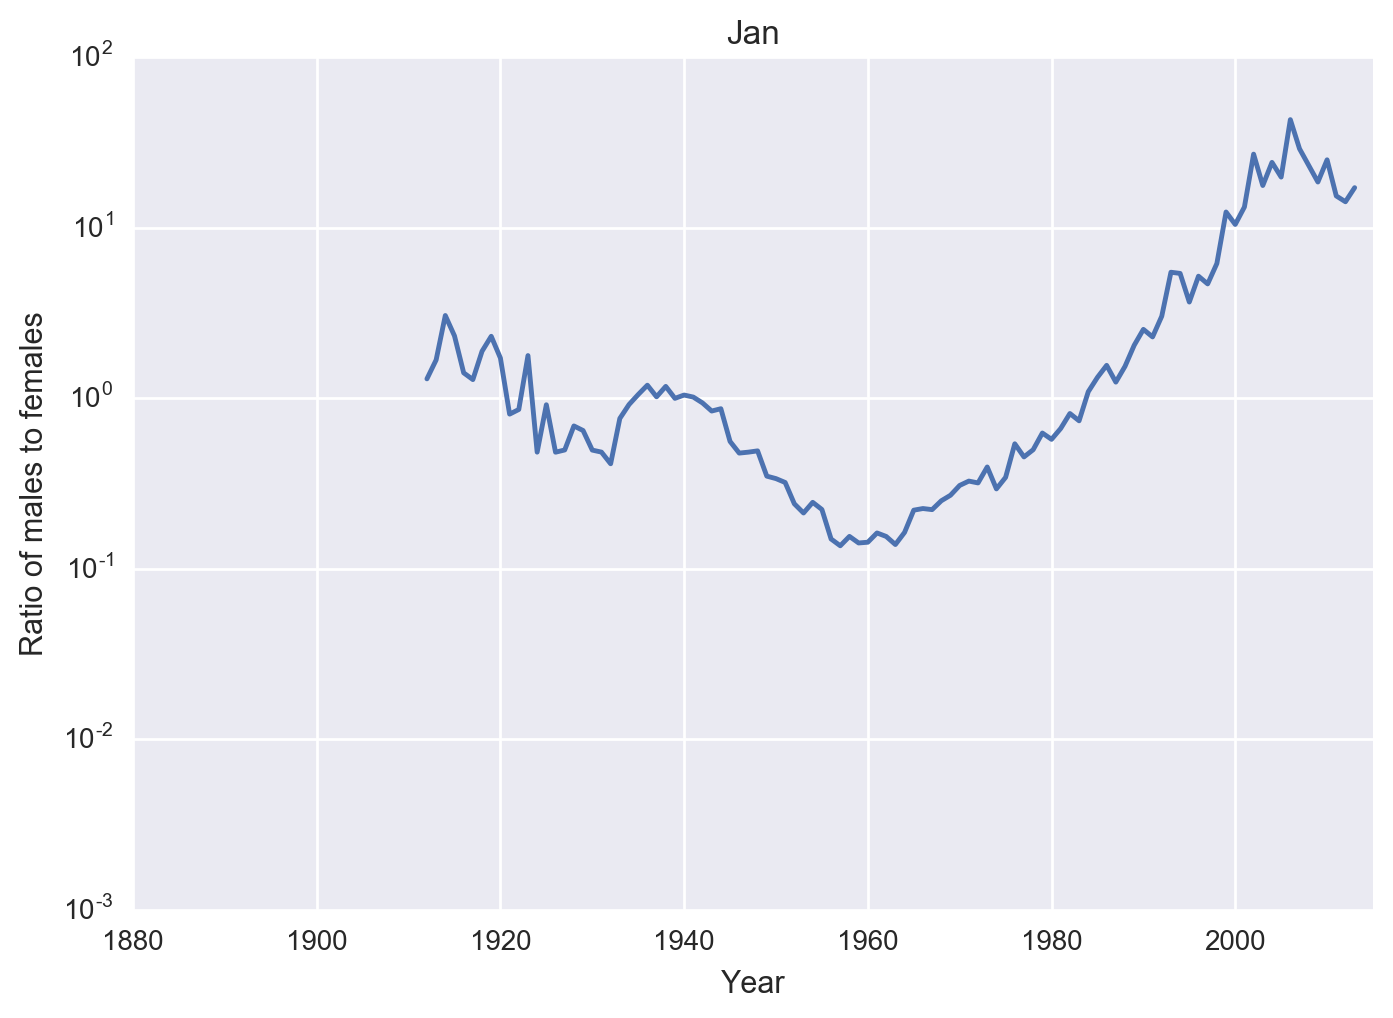

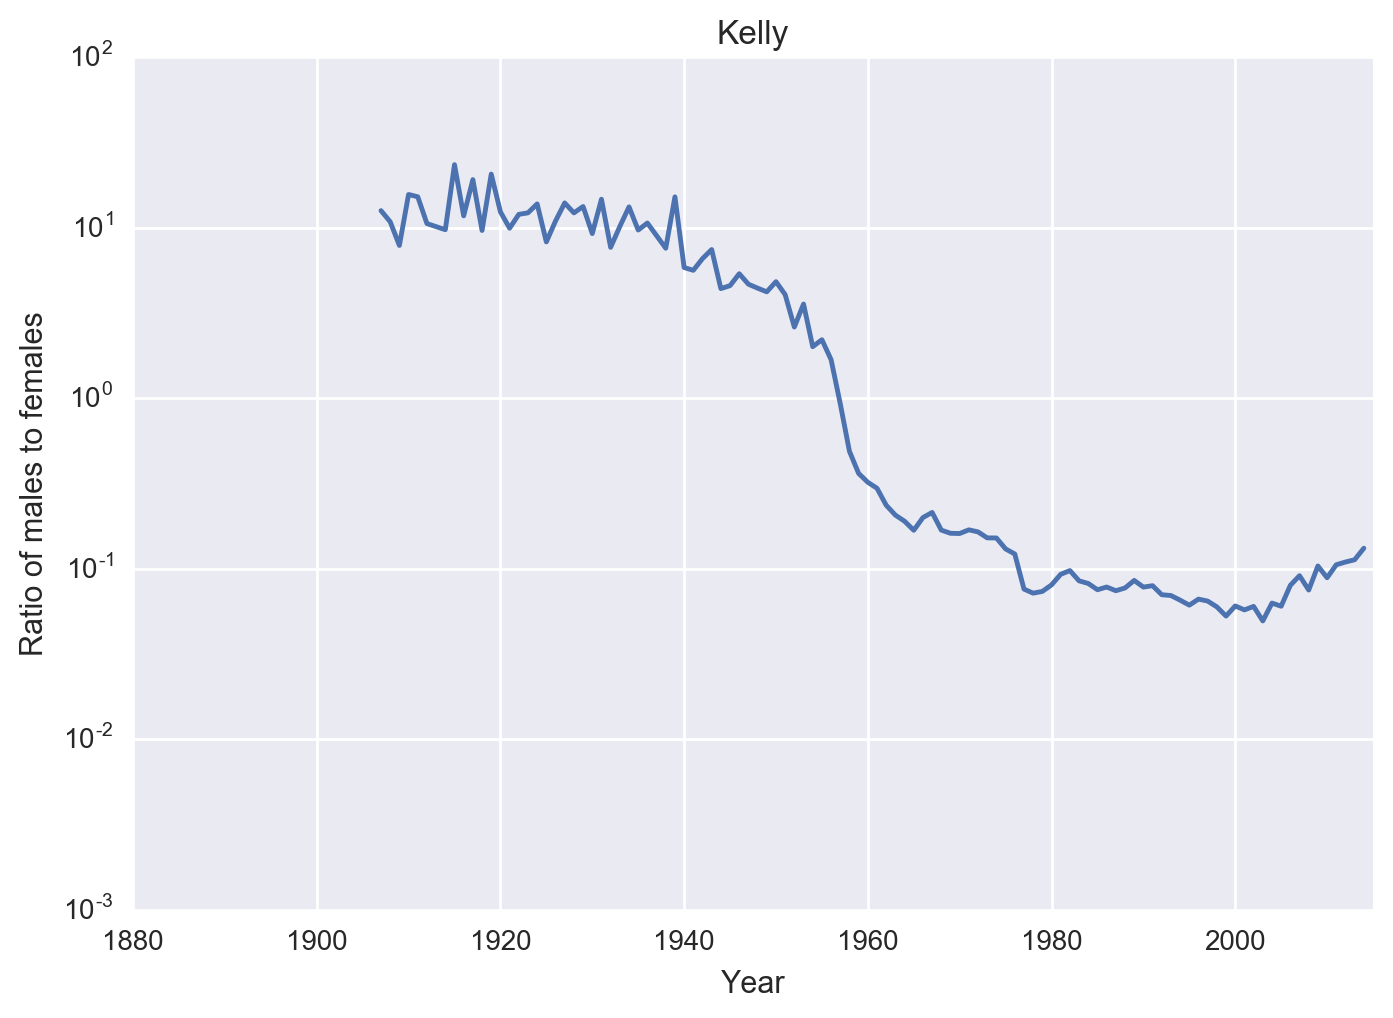

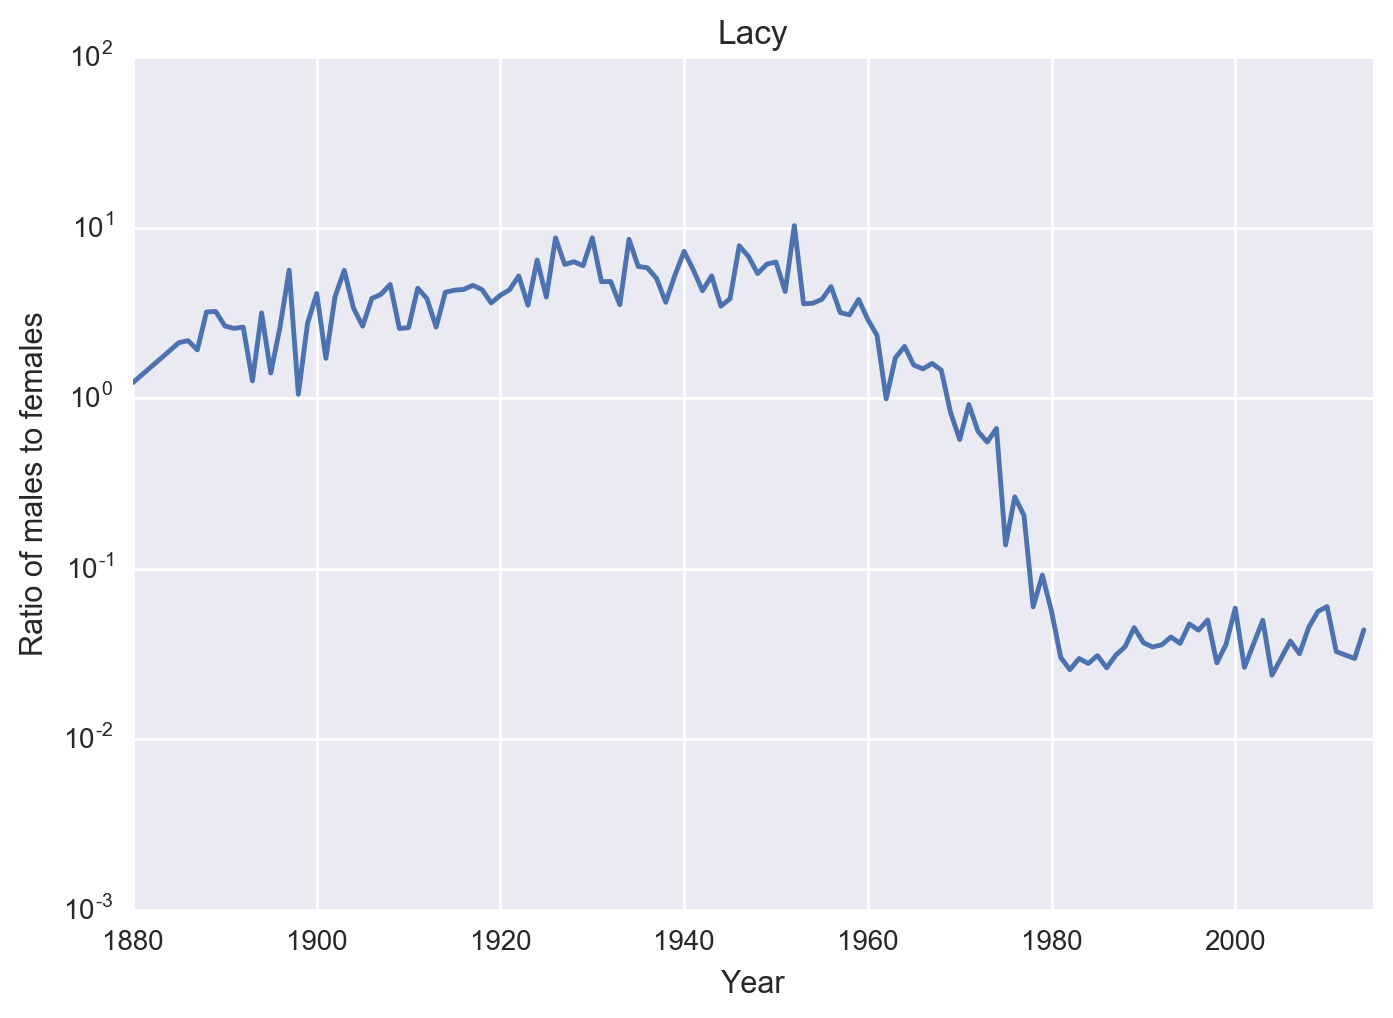

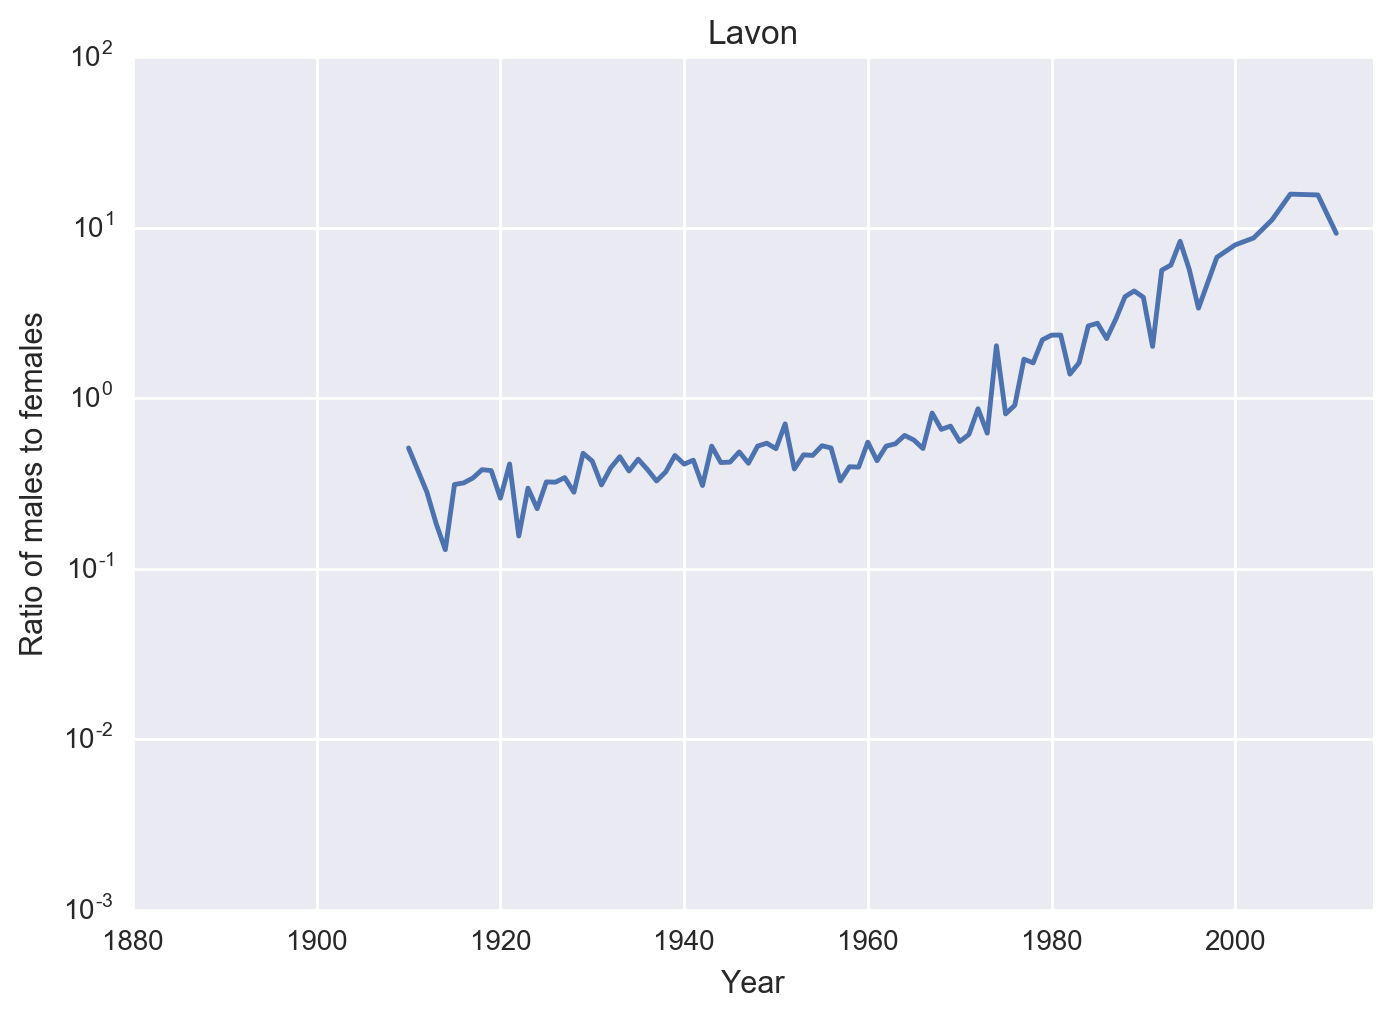

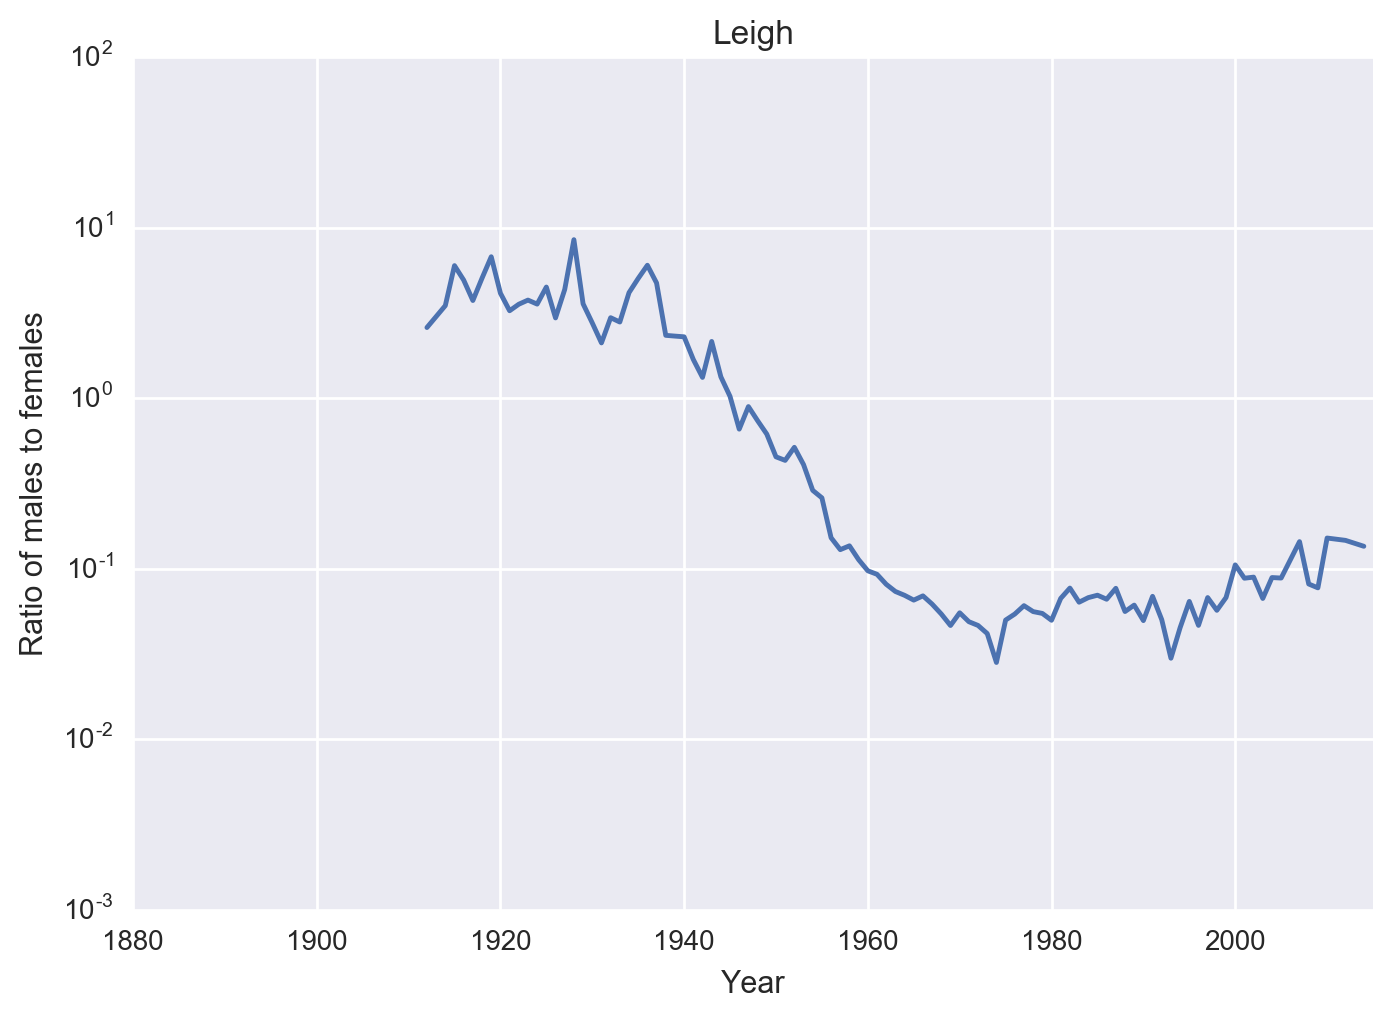

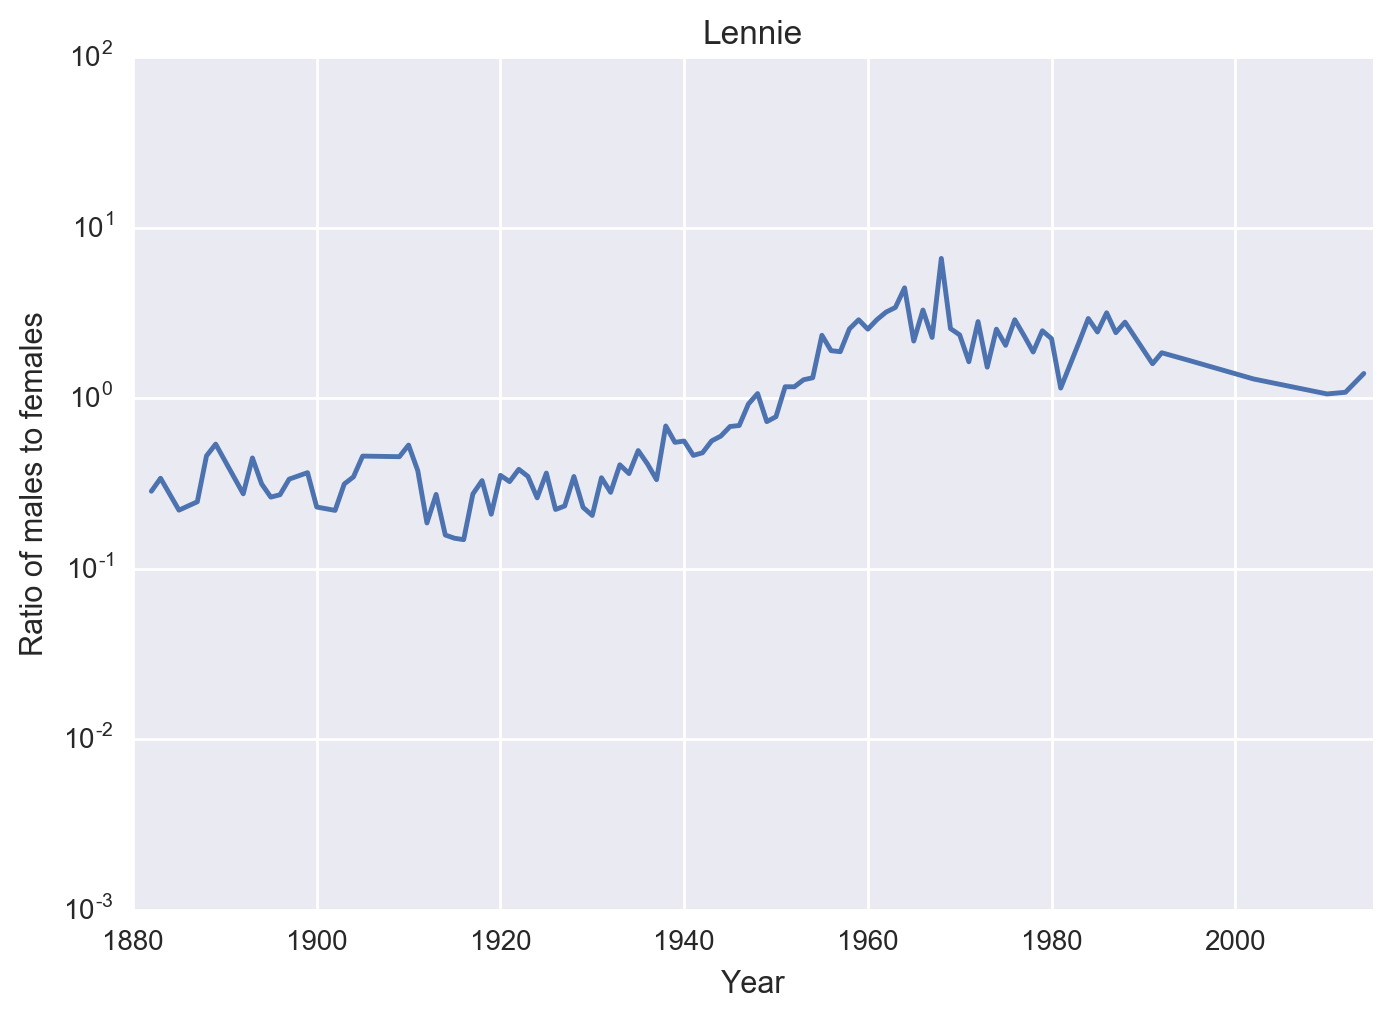

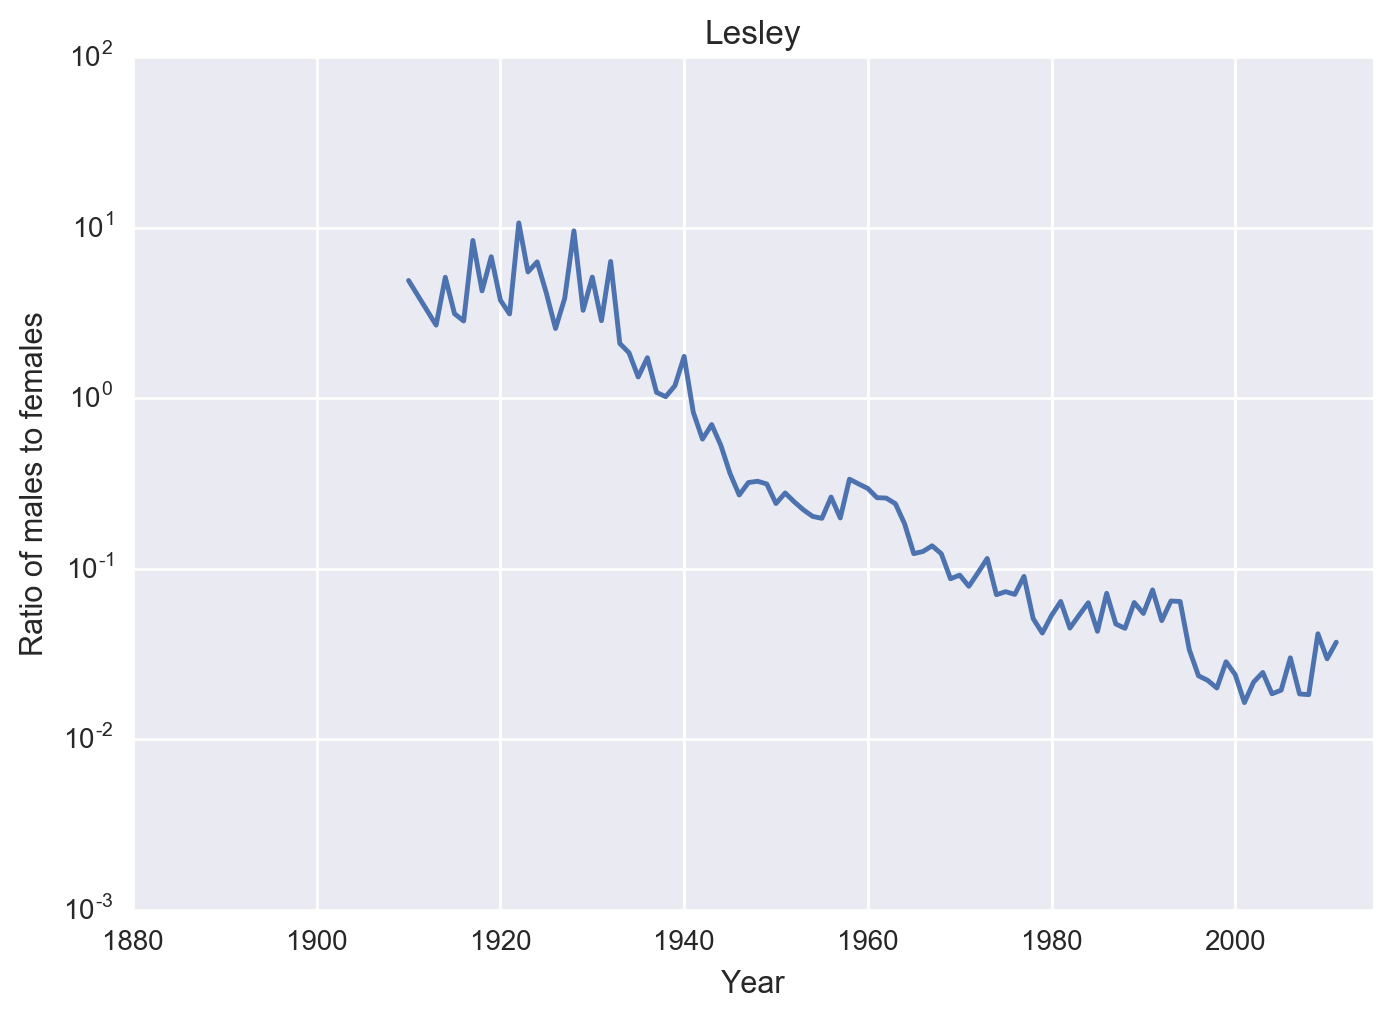

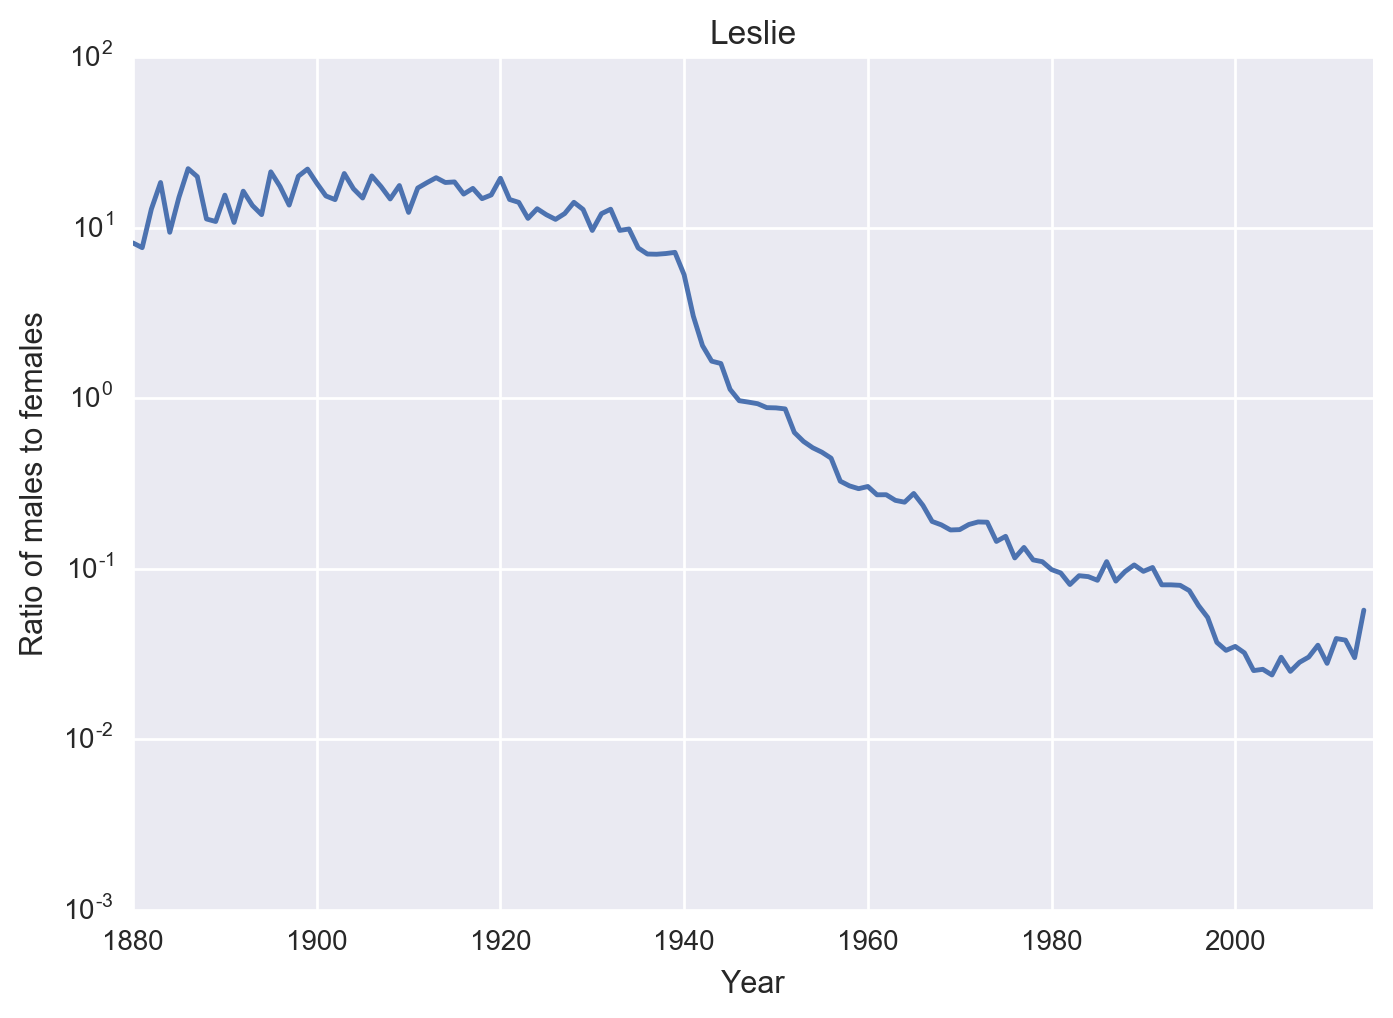

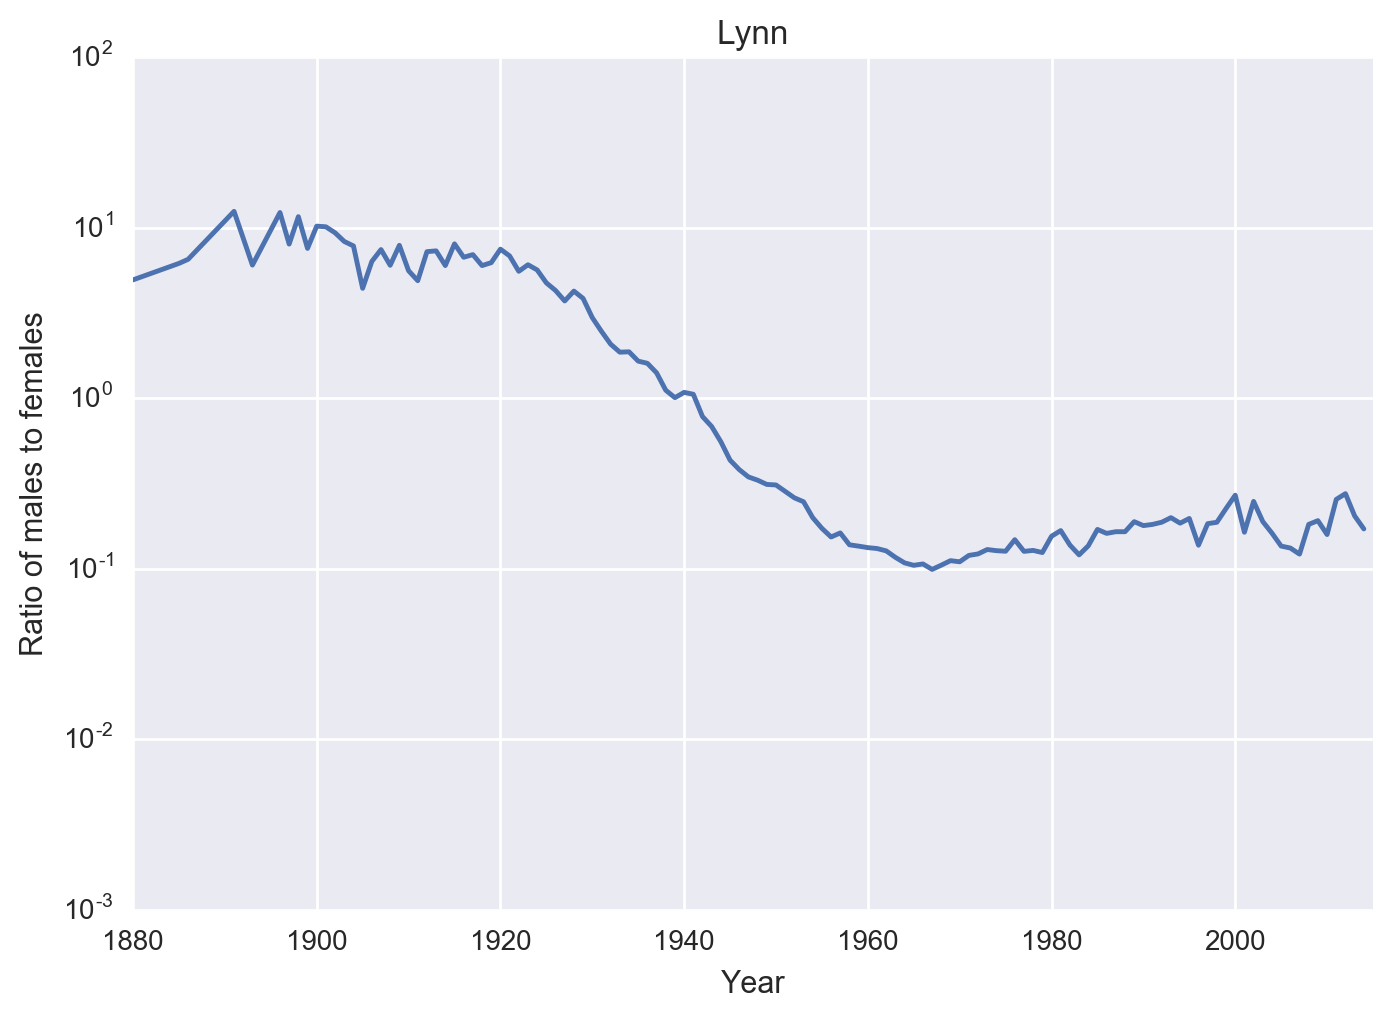

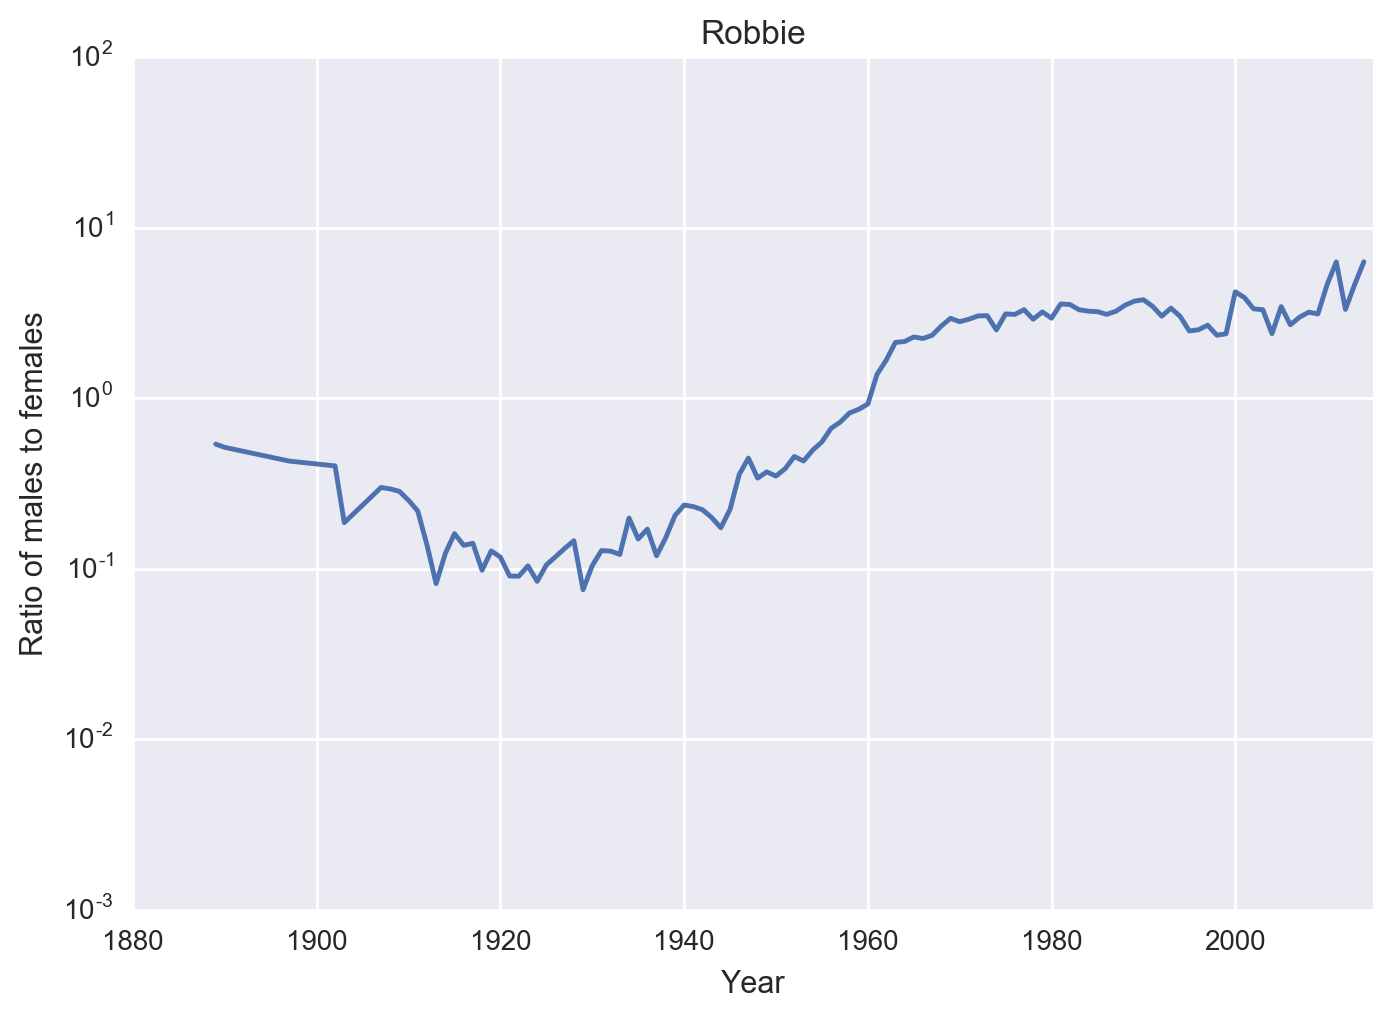

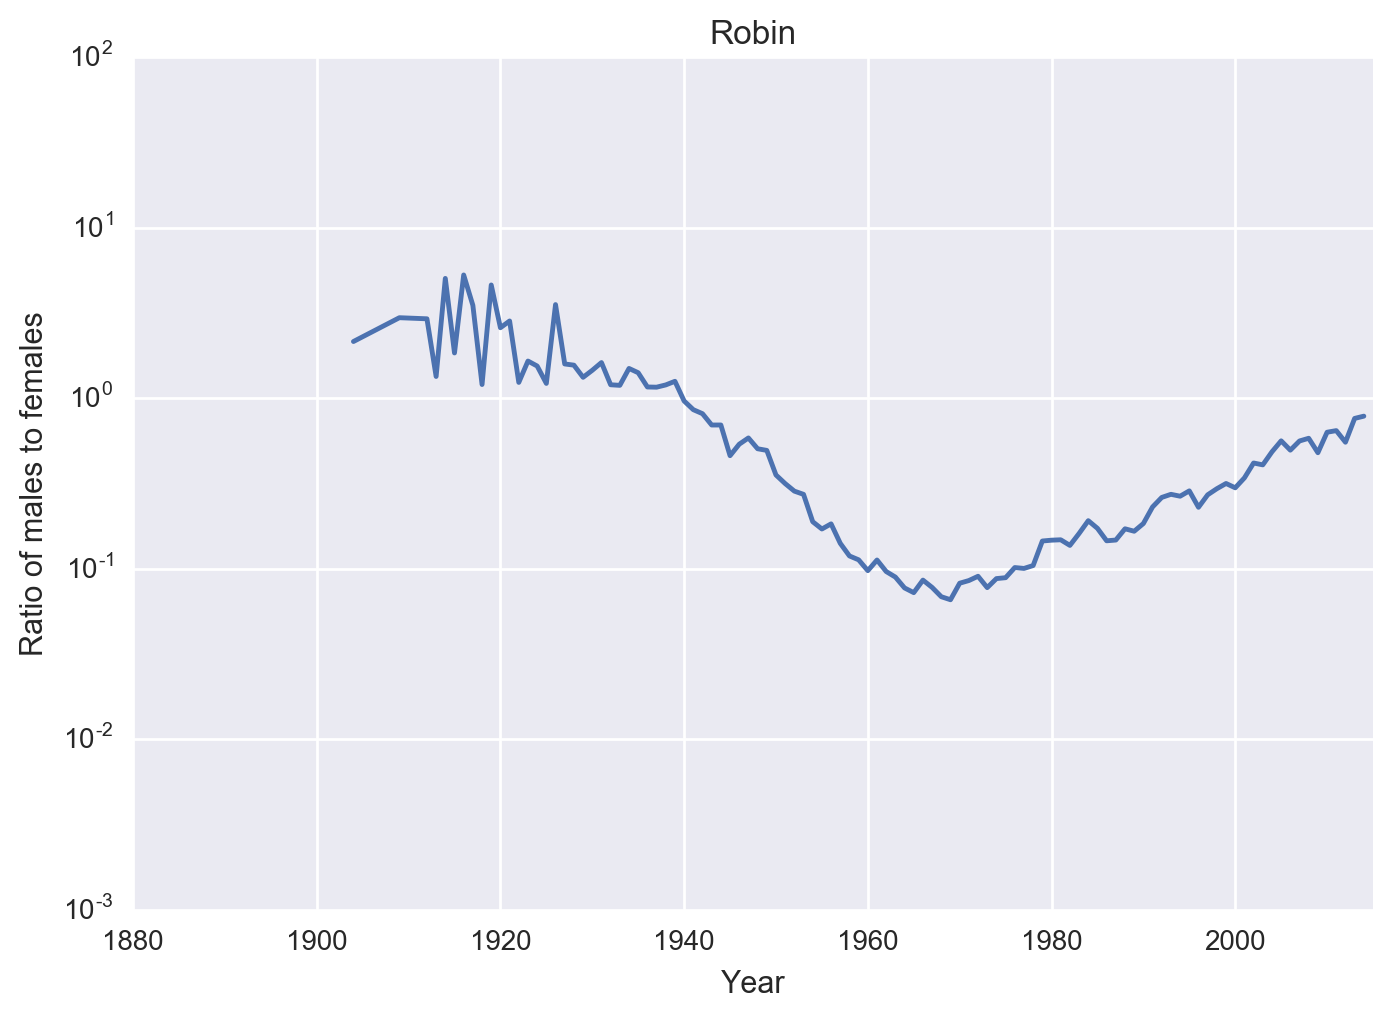

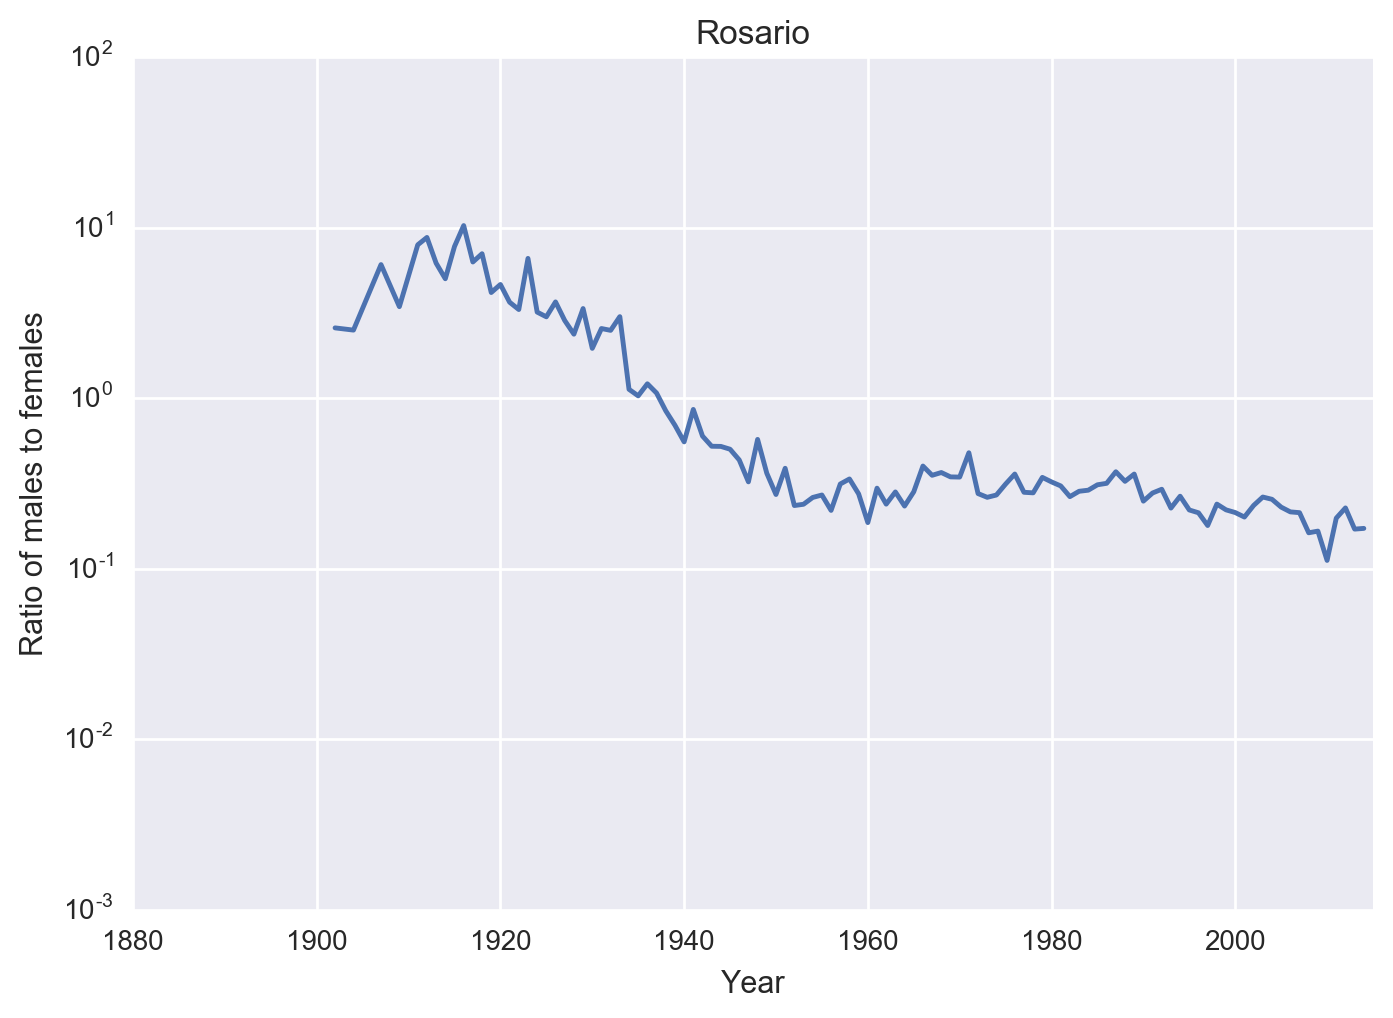

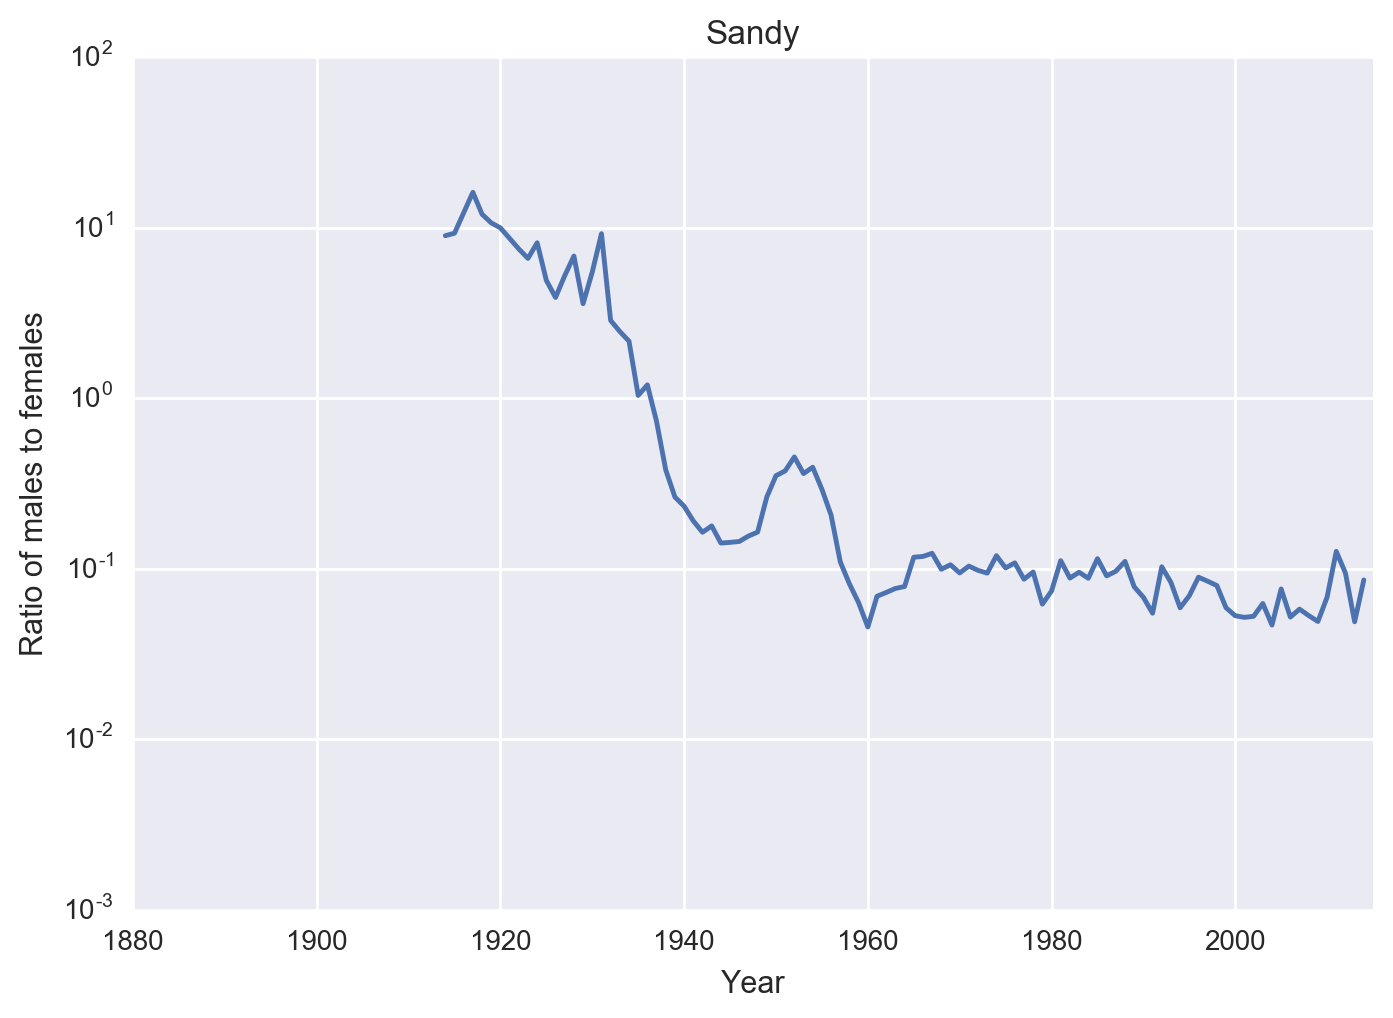

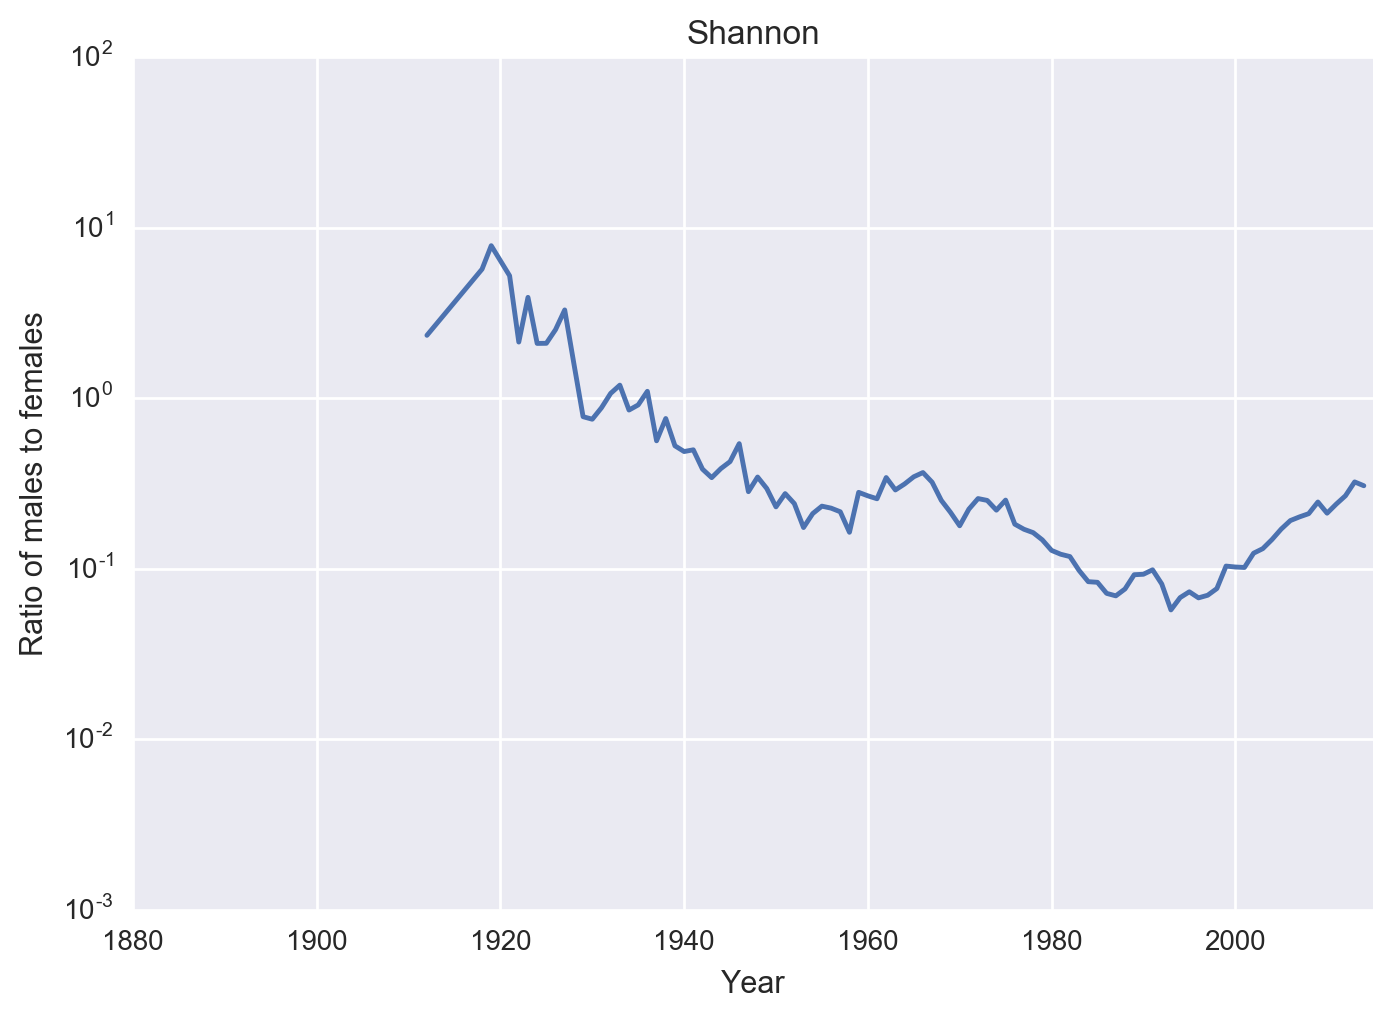

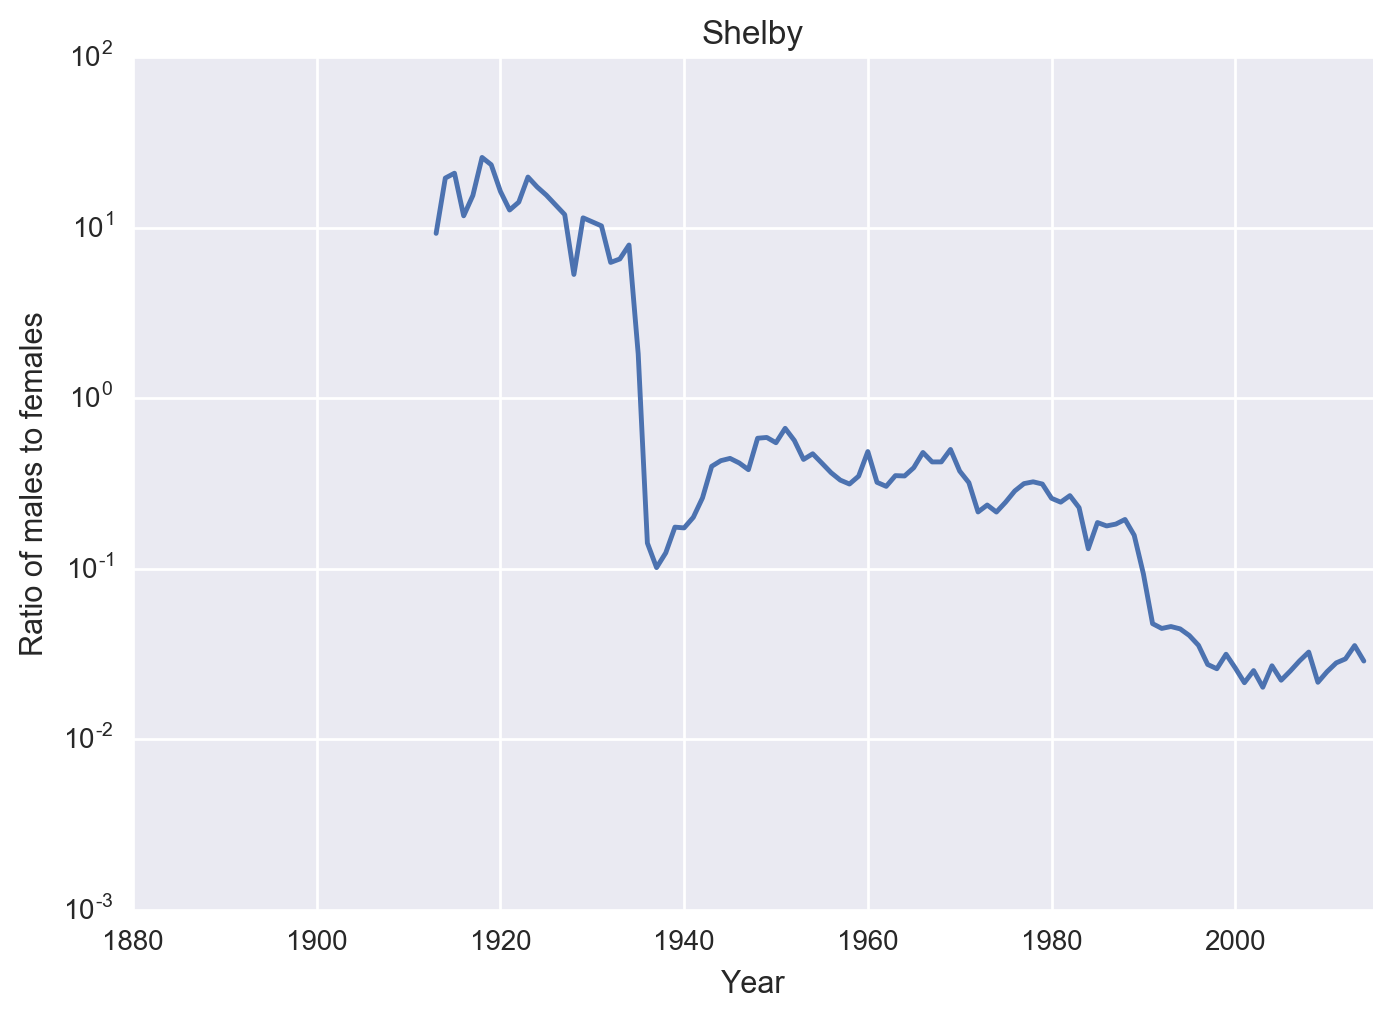

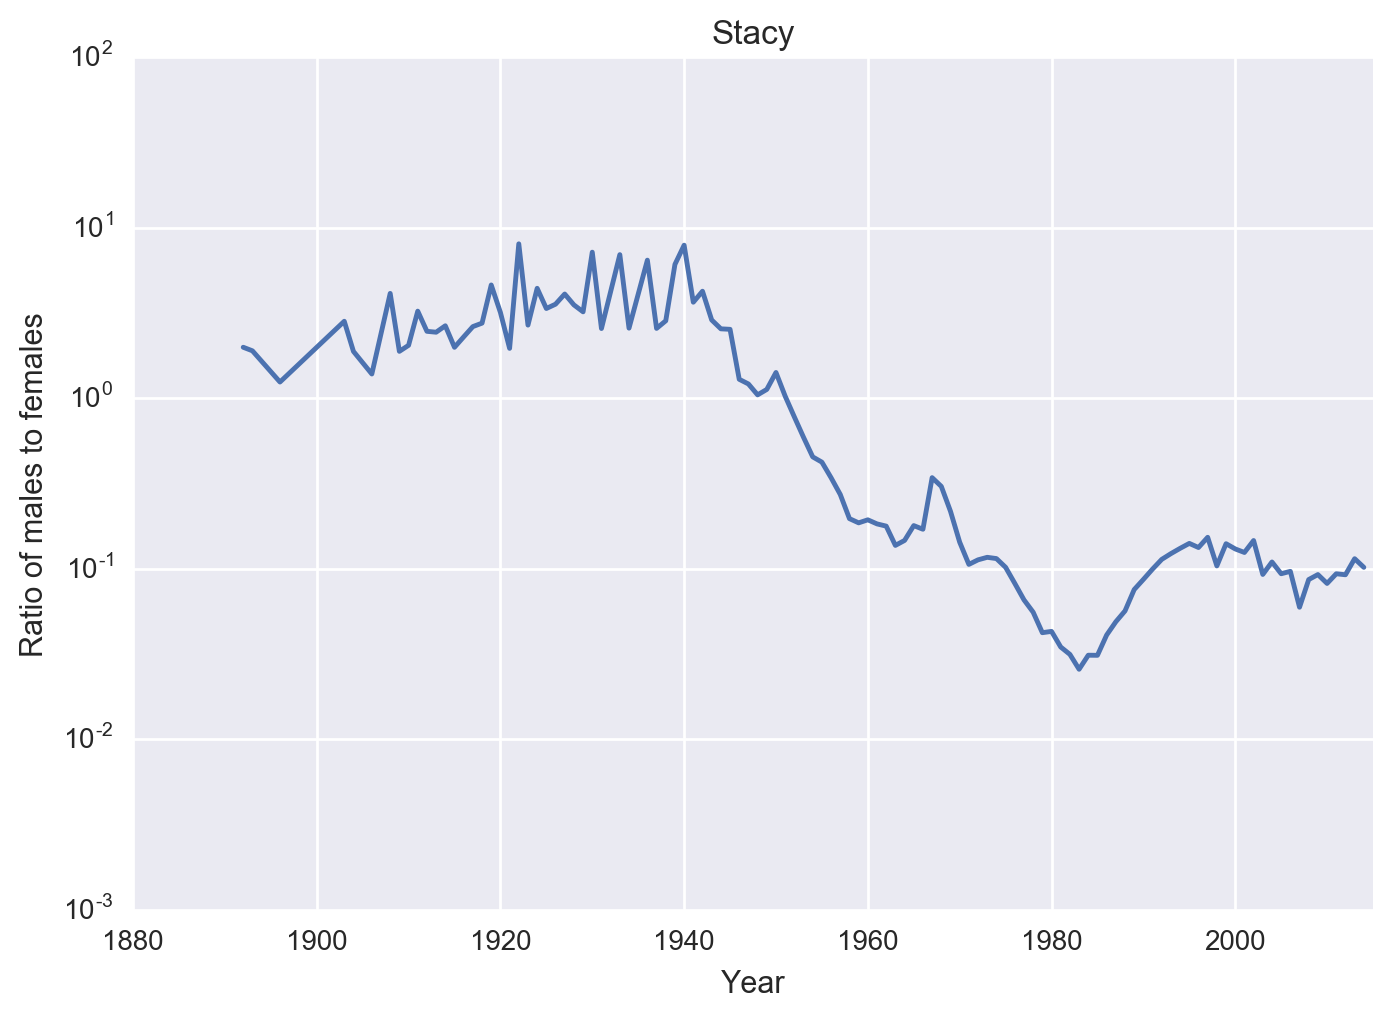

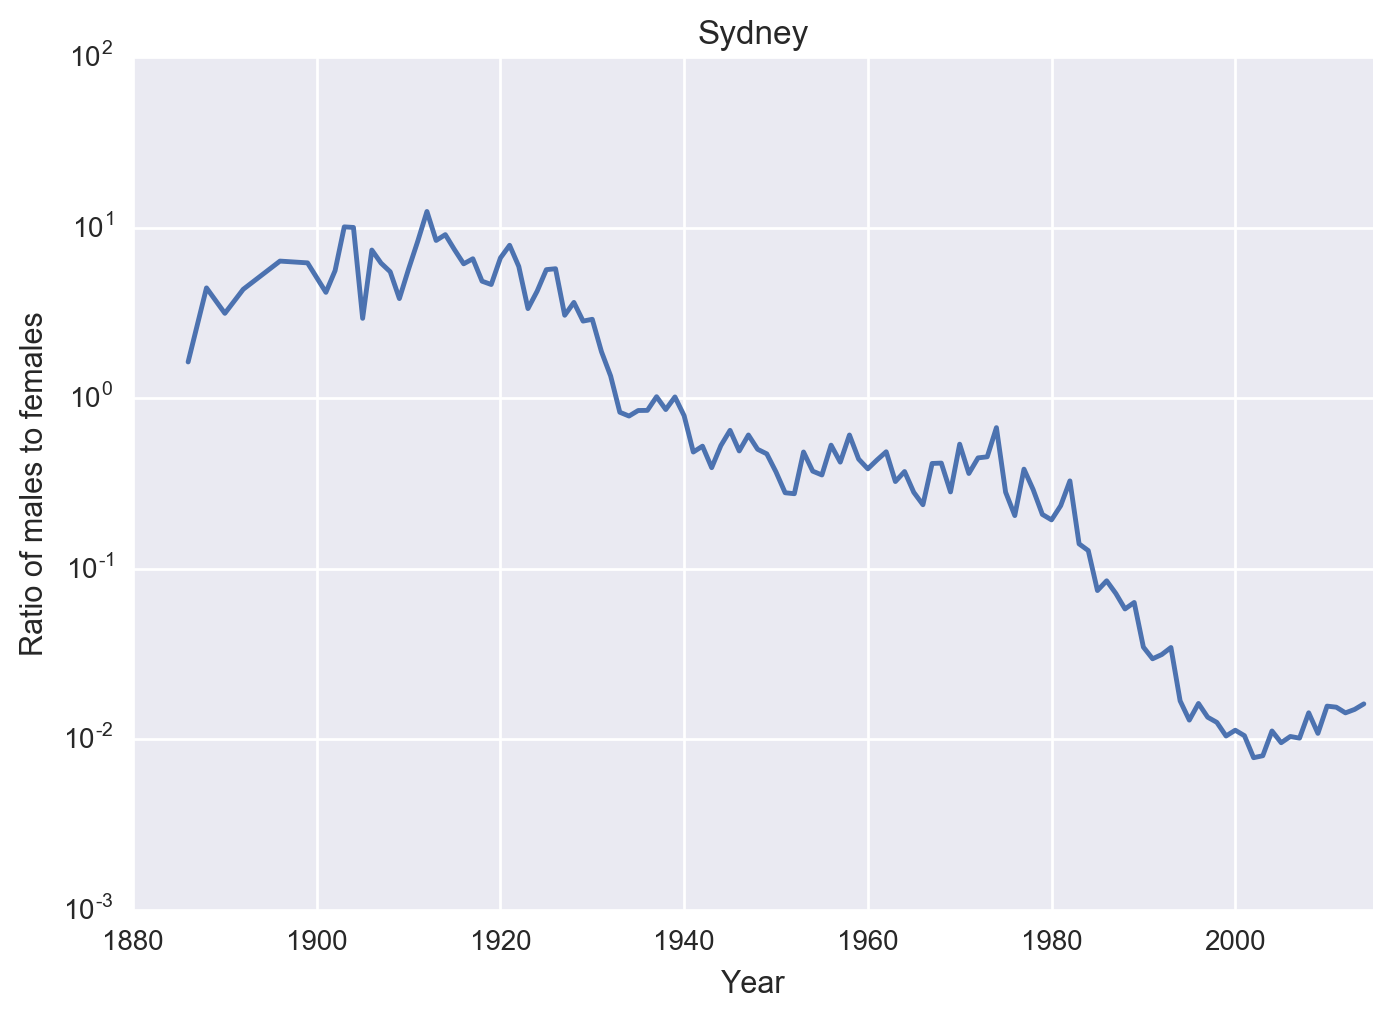

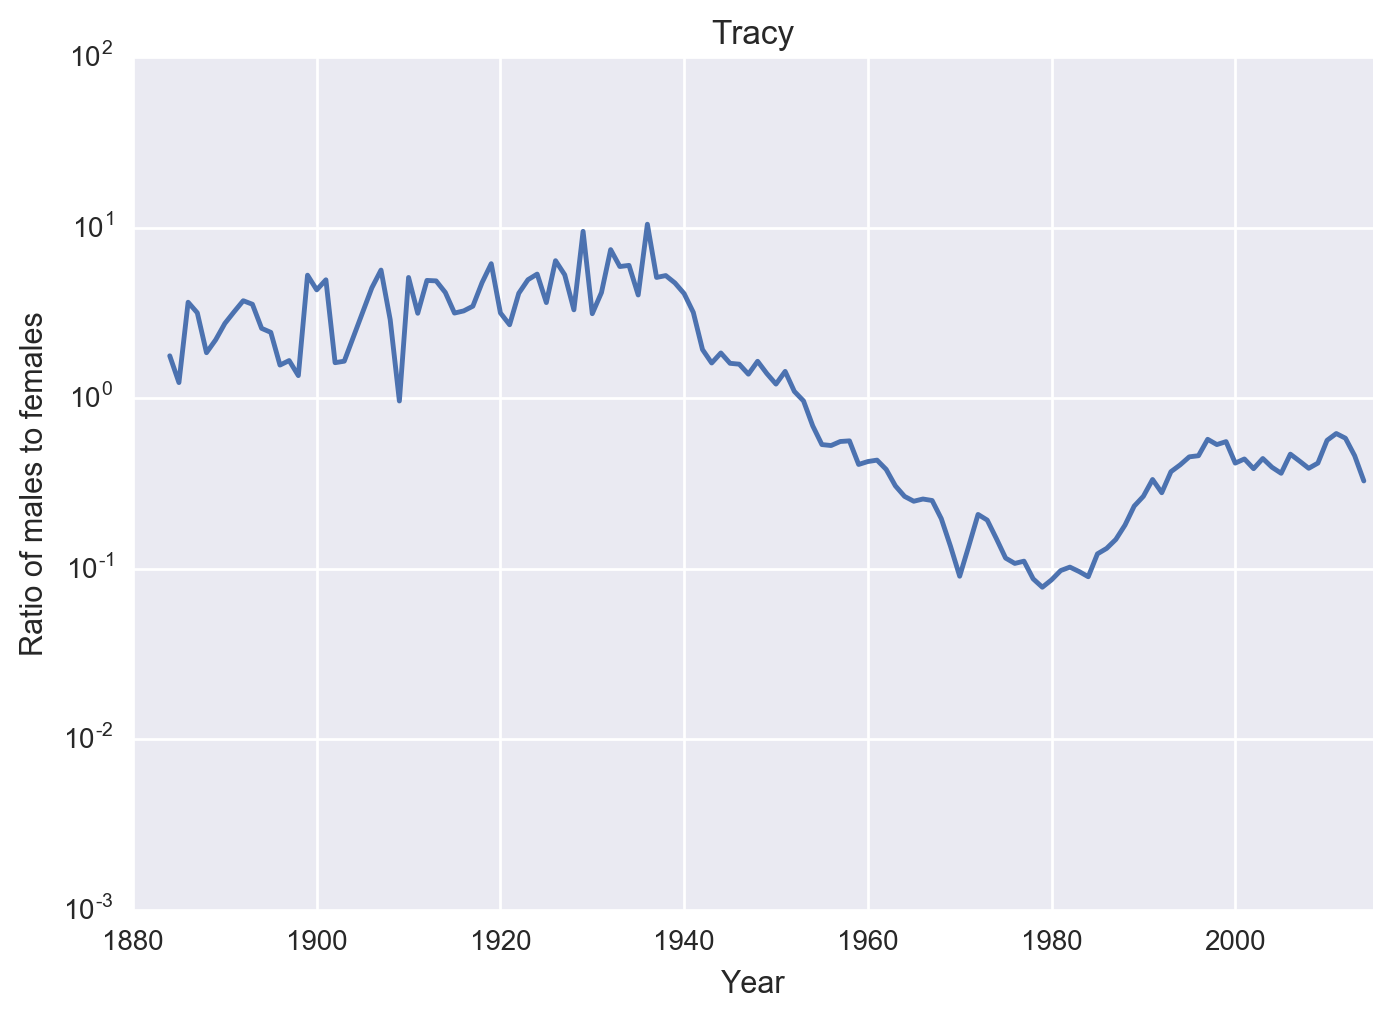

In [8]:
for n, df_sub in df_ratio.groupby("Name"):
  ax = df_sub.plot.line("Year","Ratio", title=n, logy=True, legend=False, xlim=(1880,2015), ylim=(1e-3,1e2))
  ax.set_ylabel("Ratio of males to females")